# Подключения к гугл-диску

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
deploma_root = 'drive/MyDrive/ReserveImportantDataCopy/MyProjects/University/8 SEMESTER/Deploma'
seed = 42

In [ ]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import seaborn as sns
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

import itertools
import logging
from typing import Any, Dict, Iterable, List, Optional, Tuple, Type
import tqdm

from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
# import fvcore
# from fvcore.nn.precise_bn import update_bn_stats

import argparse
import sys
import datetime
import math
import json
from pathlib import Path
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.image as mp_image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
import seaborn as sns

from PIL import Image
import torch.distributed as dist
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms
from torchvision import models as torchvision_models
import cpuinfo

from skimage.io import imread

torch.cuda.empty_cache()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **Выбор архитектуры модели классификации**



# Скачивание датасета

In [ ]:
!unzip -q drive/MyDrive/ReserveImportantDataCopy/MyProjects/University/'8 SEMESTER'/Deploma/MyProject/Data/Dermnet.zip -d Dermnet

In [ ]:
!ls Dermnet/train

'Acne and Rosacea Photos'
'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions'
'Atopic Dermatitis Photos'
'Bullous Disease Photos'
'Cellulitis Impetigo and other Bacterial Infections'
'Eczema Photos'
'Exanthems and Drug Eruptions'
'Hair Loss Photos Alopecia and other Hair Diseases'
'Herpes HPV and other STDs Photos'
'Light Diseases and Disorders of Pigmentation'
'Lupus and other Connective Tissue diseases'
'Melanoma Skin Cancer Nevi and Moles'
'Nail Fungus and other Nail Disease'
'Poison Ivy Photos and other Contact Dermatitis'
'Psoriasis pictures Lichen Planus and related diseases'
'Scabies Lyme Disease and other Infestations and Bites'
'Seborrheic Keratoses and other Benign Tumors'
'Systemic Disease'
'Tinea Ringworm Candidiasis and other Fungal Infections'
'Urticaria Hives'
'Vascular Tumors'
'Vasculitis Photos'
'Warts Molluscum and other Viral Infections'


# Установка компонентов

In [ ]:
!pip install fvcore=='0.1.dev200114'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.dev200114-py3-none-any.whl size=30357 sha256=f1ac82398d97d611bd693851d5f081e7132b60328eb5c32ab9995d88890ed3dc
  Stored in directory: /root/.cache/pip/wheels/d2/f7/63/b336a1e4b1036e509fcf786c401ec76b52bcb85fa46ab1584b
Successfully built fvcore


# Анализ датасета

In [ ]:
DIR = "Dermnet"
DIR_TRAIN = "Dermnet/train/"
DIR_TEST = "Dermnet/test/"

In [ ]:
classes = os.listdir(DIR_TRAIN)
print("Total Classes: ", len(classes))

#Подсчитываем число изображений в train, test, valid

train_count = 0
valid_count = 0
test_count = 0

classes_df = []
for _class in classes:
    class_dict = {}
    train_count += len(os.listdir(DIR_TRAIN + _class))
    test_count += len(os.listdir(DIR_TEST + _class))
    #print(f'Class {_class}: train amount {train_count}, test amount {test_count} ')
    class_dict.update({'Class': _class, 'Train': len(os.listdir(DIR_TRAIN + _class)), 'Test': len(os.listdir(DIR_TEST + _class)) })
    classes_df.append(class_dict)

print("Total train images: ",train_count)
print("Total test images: ",test_count)
print(pd.DataFrame(classes_df))

Total Classes:  23
Total train images:  15557
Total test images:  4002
                                                Class  Train  Test
0                  Nail Fungus and other Nail Disease   1040   261
1                        Exanthems and Drug Eruptions    404   101
2   Psoriasis pictures Lichen Planus and related d...   1405   352
3                             Acne and Rosacea Photos    840   312
4          Lupus and other Connective Tissue diseases    420   105
5   Hair Loss Photos Alopecia and other Hair Diseases    239    60
6   Scabies Lyme Disease and other Infestations an...    431   108
7                                    Systemic Disease    606   152
8                                   Vasculitis Photos    416   105
9                            Atopic Dermatitis Photos    489   123
10                                    Urticaria Hives    212    53
11                                    Vascular Tumors    482   121
12         Warts Molluscum and other Viral Infections   10

In [ ]:
# Creating a list of all images : DIR_TRAIN/class_folder/img.jpg 
#   A dict for mapping class labels to index

train_imgs = []
test_imgs = []

for _class in classes:
    
    for img in os.listdir(DIR_TRAIN + _class):
        train_imgs.append(DIR_TRAIN + _class + "/" + img)
    
    for img in os.listdir(DIR_TEST + _class):
        test_imgs.append(DIR_TEST + _class + "/" + img)

class_to_int = {classes[i] : i for i in range(len(classes))}

In [ ]:
class_to_int

{'Nail Fungus and other Nail Disease': 0,
 'Exanthems and Drug Eruptions': 1,
 'Psoriasis pictures Lichen Planus and related diseases': 2,
 'Acne and Rosacea Photos': 3,
 'Lupus and other Connective Tissue diseases': 4,
 'Hair Loss Photos Alopecia and other Hair Diseases': 5,
 'Scabies Lyme Disease and other Infestations and Bites': 6,
 'Systemic Disease': 7,
 'Vasculitis Photos': 8,
 'Atopic Dermatitis Photos': 9,
 'Urticaria Hives': 10,
 'Vascular Tumors': 11,
 'Warts Molluscum and other Viral Infections': 12,
 'Herpes HPV and other STDs Photos': 13,
 'Poison Ivy Photos and other Contact Dermatitis': 14,
 'Eczema Photos': 15,
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 16,
 'Seborrheic Keratoses and other Benign Tumors': 17,
 'Cellulitis Impetigo and other Bacterial Infections': 18,
 'Melanoma Skin Cancer Nevi and Moles': 19,
 'Light Diseases and Disorders of Pigmentation': 20,
 'Bullous Disease Photos': 21,
 'Tinea Ringworm Candidiasis and other Fungal Inf

In [ ]:
int_to_class =dict(map(reversed, class_to_int.items()))
int_to_class[9]

'Atopic Dermatitis Photos'

# Аугментация данных

In [ ]:
train_dataset = ImageFolder(root = DIR_TRAIN, transform=transforms.Compose([
    transforms.RandomRotation([-8,+8]),                                           
    transforms.ColorJitter(brightness=0, contrast=0.4, saturation=0, hue=0),      
    transforms.RandomHorizontalFlip(),                                            
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))
test_dataset = ImageFolder(root = DIR_TEST, transform=transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

In [ ]:
test_part_coefficient = 0.5
test_size = int(test_part_coefficient * len(test_dataset))
valid_size = len(test_dataset) - test_size
valid_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [valid_size, test_size])

# Создание даталоадеров

In [ ]:
batch_size = 32

In [ ]:
dataloaders_dict = {}
dataloaders_dict['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
dataloaders_dict['val'] = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)

In [ ]:
src_folder = 'dermnet/train'

fig = plt.figure(figsize=(15, 35))

for root, folders, filenames in os.walk(src_folder):
    image_num = 0
    num_folders = len(folders)
    for folder in sorted(folders):
        image_num +=1
        # Найдем определенное изображение в папке
        file_name = os.listdir(os.path.join(root,folder))[8]
        # Получение полного пути от корня
        file_path = os.path.join(root,folder, file_name)
        image = mp_image.imread(file_path)
        # Добавление изображения в сетку изображений
        a = fig.add_subplot(num_folders, 3, image_num)
        image_plot = plt.imshow(image)
        a.set_title(folder)
        
fig.subplots_adjust(hspace=1, wspace=1)

plt.show()

<Figure size 1500x3500 with 0 Axes>

In [ ]:
num_classes = len(classes)

batch_size = 32

feature_extract = True
input_size = 224

В работе будут исследованы следующие архитектуры нейронных сетей: ResNet50, SegNet, Unet
Для лучшей архитектуры будет подобран наилучший лосс.

# Обучение модели

In [ ]:
class Epoch_characteristics:
  # def __init__(self, train_accuracy, val_accuracy, train_loss, val_loss, train_fbeta_score, val_fbeta_score):
  def __init__(self, accuracy, loss, precision_score, recall_score, fbeta_score, durability):
    self.time = durability
    self.accuracy = accuracy
    self.loss = loss
    self.precision_score = precision_score
    self.recall_score = recall_score
    self.fbeta_score = fbeta_score

class Environment:
  def __init__(self, cpu, gpu):
    self.cpu = cpu
    self.gpu = gpu

class Train_info:
  def __init__(self, train_epoch_characteristics, val_epoch_characteristics, environment):
    self.train_epoch_characteristics = train_epoch_characteristics
    self.val_epoch_characteristics = val_epoch_characteristics
    self.environment = environment = environment

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    train_epoch_characteristics = []
    val_epoch_characteristics = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Каждая эпоха имеет фазу тренировки и валидации
        for phase in ['train', 'val']:
            start = time.time()
            if phase == 'train':
                model.train()  
            else:               
                model.eval() 
                #update_bn_stats(model=model, data_loader=dataloaders[phase])  
                
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            finish = time.time()
            print(labels.data)
            print(preds)
            print(type(labels.data))
            print(type(preds))
            epoch_characteristics = Epoch_characteristics(durability = finish-start,
                                                          accuracy = running_corrects.double() / len(dataloaders[phase].dataset),
                                                          loss = running_loss / len(dataloaders[phase].dataset),
                                                          # fbeta_score = fbeta_score(labels.data.cpu().numpy(), preds.cpu().numpy(), beta = 2, average='micro', num_classes = len(classes)))
                                                          precision_score = precision_score(labels.data.cpu().numpy(), preds.cpu().numpy(), average='micro'),
                                                          recall_score = recall_score(labels.data.cpu().numpy(), preds.cpu().numpy(), average='micro'),
                                                          fbeta_score = fbeta_score(labels.data.cpu().numpy(), preds.cpu().numpy(), beta = 2, average='micro'))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_characteristics.loss, epoch_characteristics.accuracy))
            
            if phase == 'val':
                val_epoch_characteristics.append(epoch_characteristics)
                if epoch_characteristics.accuracy > best_acc: 
                  best_acc = epoch_characteristics.accuracy
                  best_model_wts = copy.deepcopy(model.state_dict())
            else:
                train_epoch_characteristics.append(epoch_characteristics)
            

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
   
    # Загрузка лучших весов модели
    model.load_state_dict(best_model_wts)
    
    # return model, Train_info(train_epoch_characteristics, val_epoch_characteristics, Environment(cpu = cpuinfo.cpu.info[0]['model name'], gpu = torch.cuda.get_device_name))
    return model, Train_info(train_epoch_characteristics, val_epoch_characteristics, Environment(cpu = 'cpu', gpu = 'gpu'))

In [ ]:
# cpu = cpuinfo.cpu.info[0]['model name']
# cpuinfo.main()
# !df -h
# !cat /proc/cpuinfo
# !cat /proc/meminfo

In [ ]:
def test_model(model, dl, normalize=True):
  model.eval()
  true_labels = []
  predictions = []
  total = 0
  num_correct = 0
  with torch.no_grad():
      for images, labels in dl:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          predicted = torch.argmax(outputs.data,-1)        
          true_labels.append(labels.cpu().numpy())
          predictions.append(predicted.cpu().numpy())
          total += labels.size(0)
          num_correct += (predicted == labels).sum()
      print(f"Test Accuracy of the model: {float(num_correct)/float(total)*100:.2f}")    
      true_labels = np.hstack(true_labels)
      predictions = np.hstack(predictions)
      
  return true_labels, predictions

In [ ]:
# x, y - поиск изображени из класса x имеющего класс y
def test(model, dl, x, y, normalize=True):
  model.eval()
  true_labels = []
  predictions = []
  images_list = []

  with torch.no_grad():
      for images, labels in dl:
          images_list.append(images.cpu().numpy())
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          predicted = torch.argmax(outputs.data,-1)        
          true_labels.append(labels.cpu().numpy())
          predictions.append(predicted.cpu().numpy())
    
  for n in range(60):
    for i in range(32):
      if (true_labels[n][i] == x)  & (predictions[n][i] == y):
        #inv_tensor = inv_normalize(image_list[n][i]])
        plt.imshow(np.transpose(images_list[n][i], (1, 2, 0)))
        plt.show()

Переключение на видеокарту, если она доступна

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
num_epochs = 8
criterion = nn.CrossEntropyLoss()

###Resnet50, pretrained, 5 epochs + augmentation: RandomRotation(), ColorJitter(), RandomHorizontalFlip().

Объявим функции для построения графиков лосса и скора

In [ ]:
def tensor_list_to_list(tensor_list):
  result_list = []
  for i in tensor_list:
    result_list.append(i.cpu().detach())
  return result_list
  # return tensor_list
  
def show_metric_tensor(tensor_list_train, tensor_list_val, metric_name):
  plt.figure(figsize=(12, 8))
  plt.plot(tensor_list_train, label="train")
  plt.plot(tensor_list_val, label="val")
  # plt.xlabel(metric_name)
  plt.title(metric_name)
  plt.legend()
  plt.show()

def show_metric(tensor_list_train, tensor_list_val, metric_name):
  plt.figure(figsize=(12, 8))
  plt.plot(tensor_list_to_list(tensor_list_train), label="train")
  plt.plot(tensor_list_to_list(tensor_list_val), label="val")
  plt.title(metric_name)
  plt.legend()
  # plt.xlabel()
  plt.show()

def show_metrics(train_info):
  train_loss = []
  train_accuracy = []
  train_precision_score = []
  train_recall_score = []
  train_fbeta_score = []
  train_time = []
  for i in range(len(train_info.train_epoch_characteristics)):
    train_loss.append(train_info.train_epoch_characteristics[i].loss)
    train_accuracy.append(train_info.train_epoch_characteristics[i].accuracy)
    train_precision_score.append(train_info.train_epoch_characteristics[i].precision_score)
    train_recall_score.append(train_info.train_epoch_characteristics[i].recall_score)
    train_fbeta_score.append(train_info.train_epoch_characteristics[i].fbeta_score)
    train_time.append(train_info.train_epoch_characteristics[i].time)
  val_loss = []
  val_accuracy = []
  val_precision_score = []
  val_recall_score = []
  val_fbeta_score = []
  val_time = []
  for i in range(len(train_info.val_epoch_characteristics)):
    val_loss.append(train_info.val_epoch_characteristics[i].loss)
    val_accuracy.append(train_info.val_epoch_characteristics[i].accuracy)
    val_precision_score.append(train_info.val_epoch_characteristics[i].precision_score)
    val_recall_score.append(train_info.val_epoch_characteristics[i].recall_score)
    val_fbeta_score.append(train_info.val_epoch_characteristics[i].fbeta_score)
    val_time.append(train_info.val_epoch_characteristics[i].time)
  
  show_metric_tensor(train_loss, val_loss, 'Loss')
  show_metric(train_accuracy, val_accuracy, 'Accuracy')
  show_metric_tensor(train_precision_score, val_precision_score, 'precision_score')
  show_metric_tensor(train_recall_score, val_recall_score, 'recall_score')
  show_metric_tensor(train_fbeta_score, val_fbeta_score, 'fbeta_score')
  show_metric_tensor(train_time, val_time, 'time')

class Model_one_characteristic:
  def __init__(self, metric_history, model_name):
    self.metric_history = metric_history
    self.model_name = model_name


In [ ]:
def train_and_show_results (model_info):
  model_info.model.fc = nn.Linear(2048, 23, bias=True)
  model_info.model = model_info.model.to(device)
  # Adaptive momentum = RMSProp + momentum
  optimizer = torch.optim.Adam(model_info.model.parameters(), lr=0.0001)
  
  model_info.model, train_characteristics = train_model(model_info.model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)
  torch.save(model_info.model.state_dict(), model_info.filename)
  model_info.model.load_state_dict(torch.load(model_info.filename))

  true_labels, predictions = test_model(model_info.model, dataloader_test, normalize=True)
  c_matrix = confusion_matrix(true_labels, predictions)
  plt.figure(figsize=(12, 12))
  plt.title("Confusion matrix")
  sns.heatmap(c_matrix, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='g', cbar=True)
  plt.xlabel('predictions')
  plt.ylabel('true labels')
  plt.show()

  return train_characteristics

def show_accuracy_value (accuracy_values):
  print(accuracy_values)
  


Resnet50

In [ ]:
class Model_info:
  def __init__(self, model, filename):
    self.model = model
    self.filename = filename

models_list = [Model_info(model = models.resnet50(pretrained=True), filename = 'Resnet50pretrained_'),
              #  Model_info(model = models.inception.inception_v3(pretrained=True), filename = 'Inception_v3pretrained_5epoch'),
               Model_info(model = models.efficientnet_v2_s(pretrained=True), filename = 'efficientnet_v2_spretrained'),
               Model_info(model = models.densenet121(pretrained=True), filename = 'Densnetpretrained'),
               Model_info(model = models.swin_v2_t(pretrained=True), filename = 'Swin_v2_tpretrained')
               ]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 246MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

Epoch 0/11
----------
tensor([22,  0, 18, 14, 20], device='cuda:0')
tensor([14, 16, 21, 22,  5], device='cuda:0')
<class 'torch.Tensor'>
<class 'torch.Tensor'>
train Loss: 1.8484 Acc: 0.4566
tensor([ 5,  4,  5, 16, 16, 14, 18, 16, 12, 16, 12,  8, 15, 19, 14,  8, 10],
       device='cuda:0')
tensor([14, 21,  5, 16, 16, 14, 18, 16,  7,  1, 12, 17, 21,  6, 14,  8, 10],
       device='cuda:0')
<class 'torch.Tensor'>
<class 'torch.Tensor'>
val Loss: 1.7630 Acc: 0.4738

Epoch 1/11
----------
tensor([22,  9,  5, 17,  9], device='cuda:0')
tensor([22,  9,  1, 16, 14], device='cuda:0')
<class 'torch.Tensor'>
<class 'torch.Tensor'>
train Loss: 1.4775 Acc: 0.5563
tensor([ 5,  4,  5, 16, 16, 14, 18, 16, 12, 16, 12,  8, 15, 19, 14,  8, 10],
       device='cuda:0')
tensor([14, 21,  5, 16,  1, 14, 18, 16,  7,  1, 12,  5, 21, 14, 14,  8, 16],
       device='cuda:0')
<class 'torch.Tensor'>
<class 'torch.Tensor'>
val Loss: 1.6380 Acc: 0.5142

Epoch 2/11
----------
tensor([ 2,  6, 16, 11,  1], device='cud

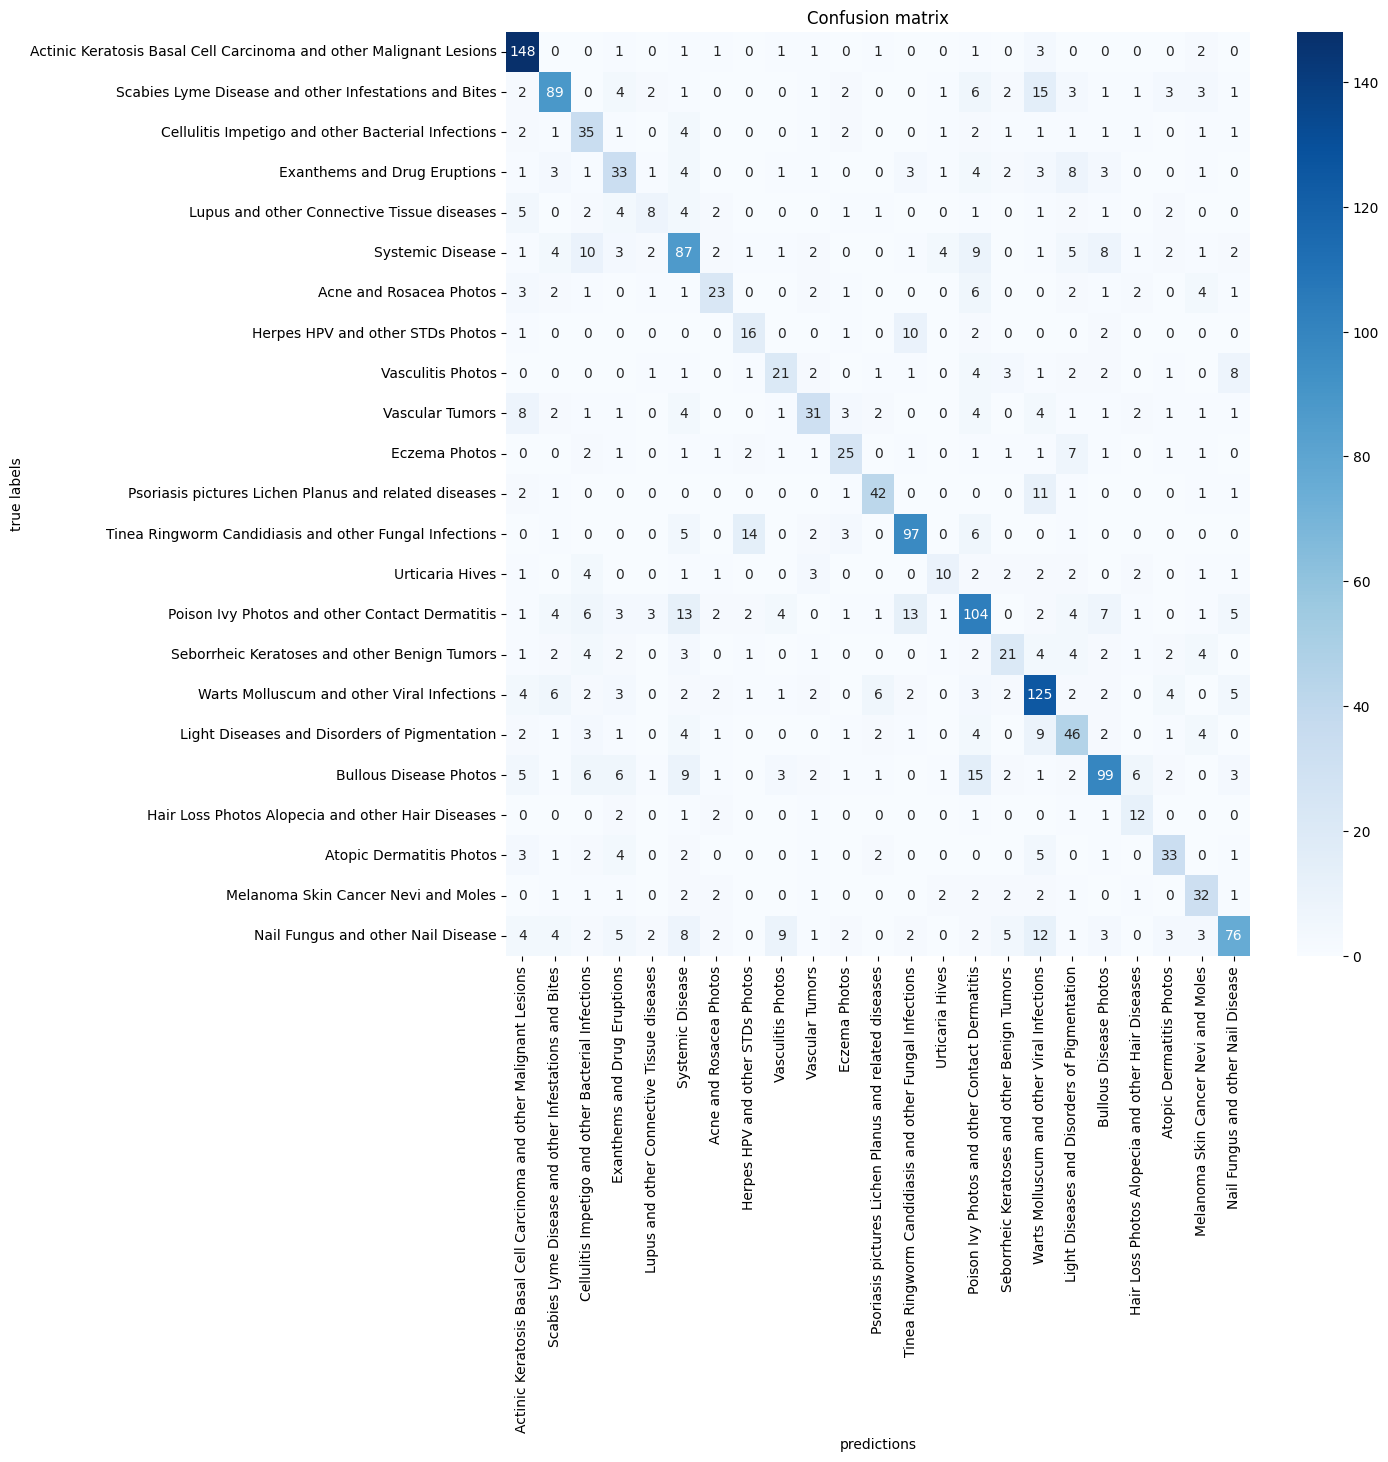

In [ ]:
resnet50_characteristics = train_and_show_results(models_list[0])

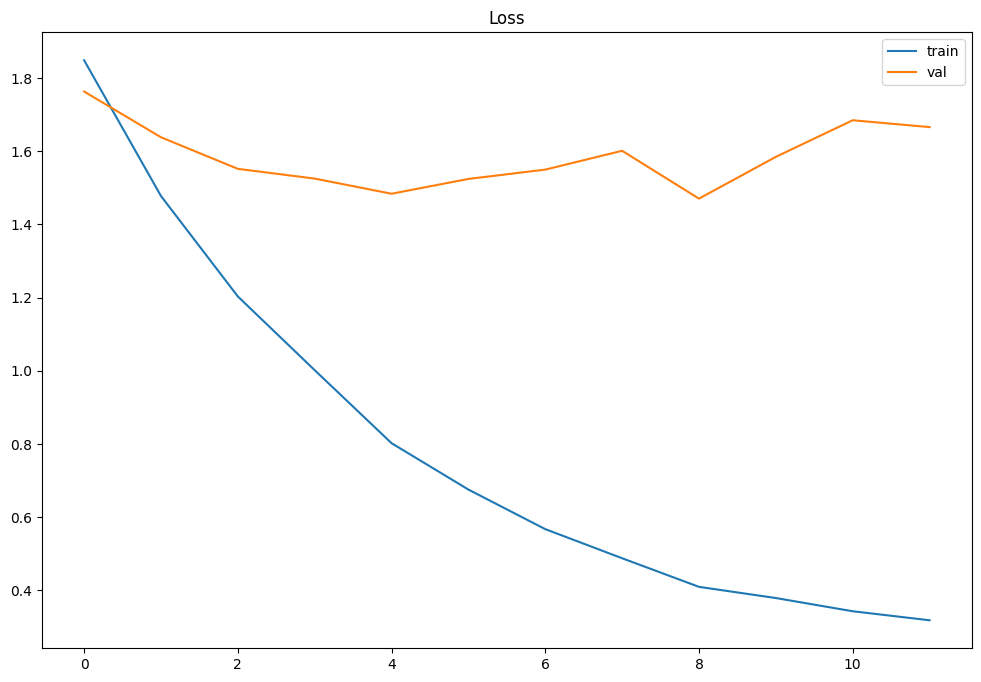

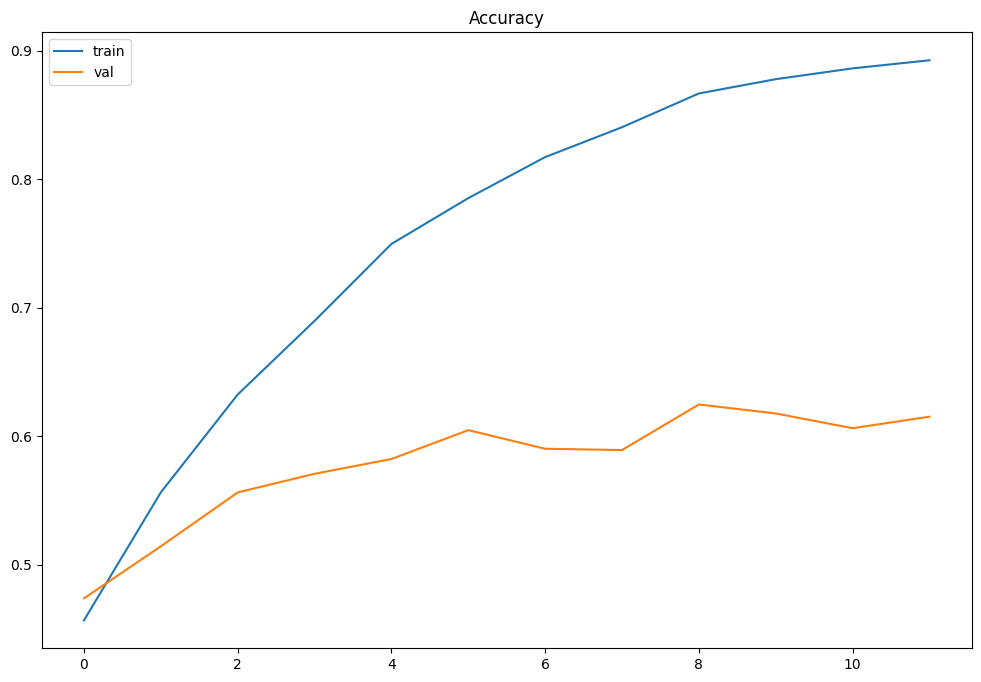

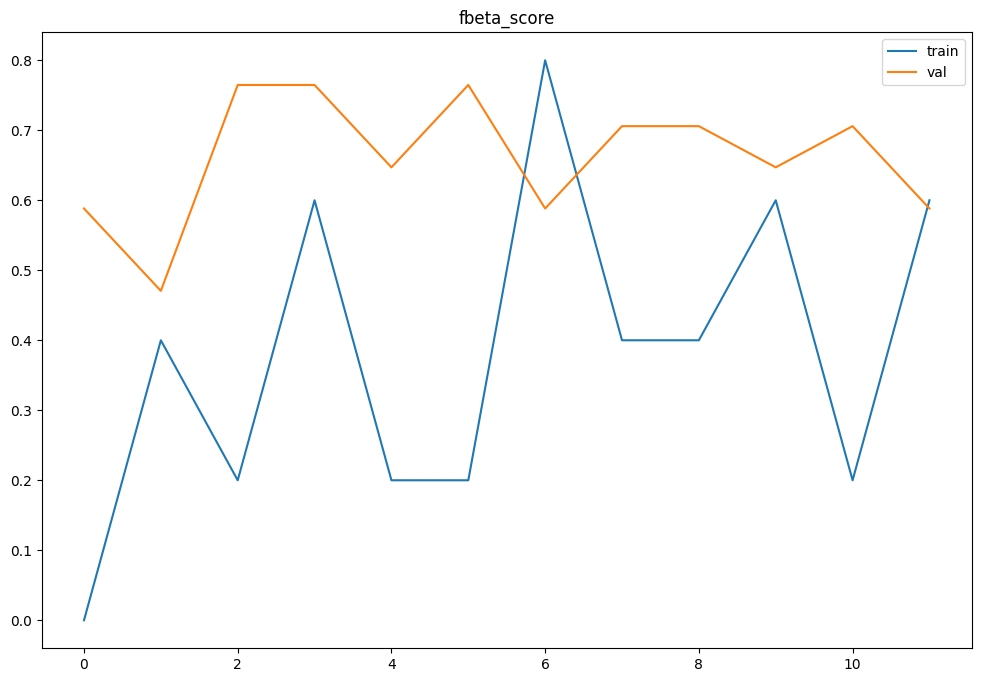

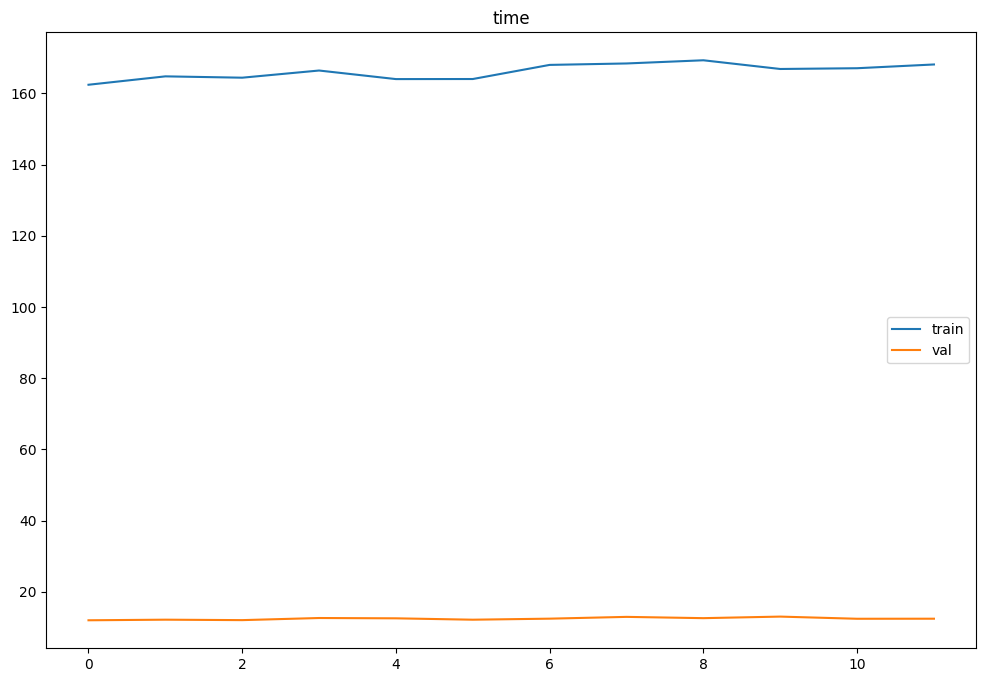

In [ ]:
show_metrics(resnet50_characteristics)

Epoch 0/11
----------
tensor([16, 22, 18, 12, 16], device='cuda:0')
tensor([20,  1, 18, 12, 15], device='cuda:0')
<class 'torch.Tensor'>
<class 'torch.Tensor'>
train Loss: 2.9407 Acc: 0.2549
tensor([ 5,  4,  5, 16, 16, 14, 18, 16, 12, 16, 12,  8, 15, 19, 14,  8, 10],
       device='cuda:0')
tensor([21, 22,  5, 14, 16, 14, 18, 16,  7, 16, 12, 21, 22, 17, 14,  8,  0],
       device='cuda:0')
<class 'torch.Tensor'>
<class 'torch.Tensor'>
val Loss: 2.0949 Acc: 0.4033

Epoch 1/11
----------
tensor([ 8,  2, 15, 14,  1], device='cuda:0')
tensor([ 8,  5, 15,  9,  1], device='cuda:0')
<class 'torch.Tensor'>
<class 'torch.Tensor'>
train Loss: 1.8914 Acc: 0.4429
tensor([ 5,  4,  5, 16, 16, 14, 18, 16, 12, 16, 12,  8, 15, 19, 14,  8, 10],
       device='cuda:0')
tensor([14, 22,  5, 16, 16, 14, 18, 16, 12,  1, 12, 17, 22, 19, 14,  8,  9],
       device='cuda:0')
<class 'torch.Tensor'>
<class 'torch.Tensor'>
val Loss: 1.6462 Acc: 0.5117

Epoch 2/11
----------
tensor([ 0,  1, 16,  5, 16], device='cud

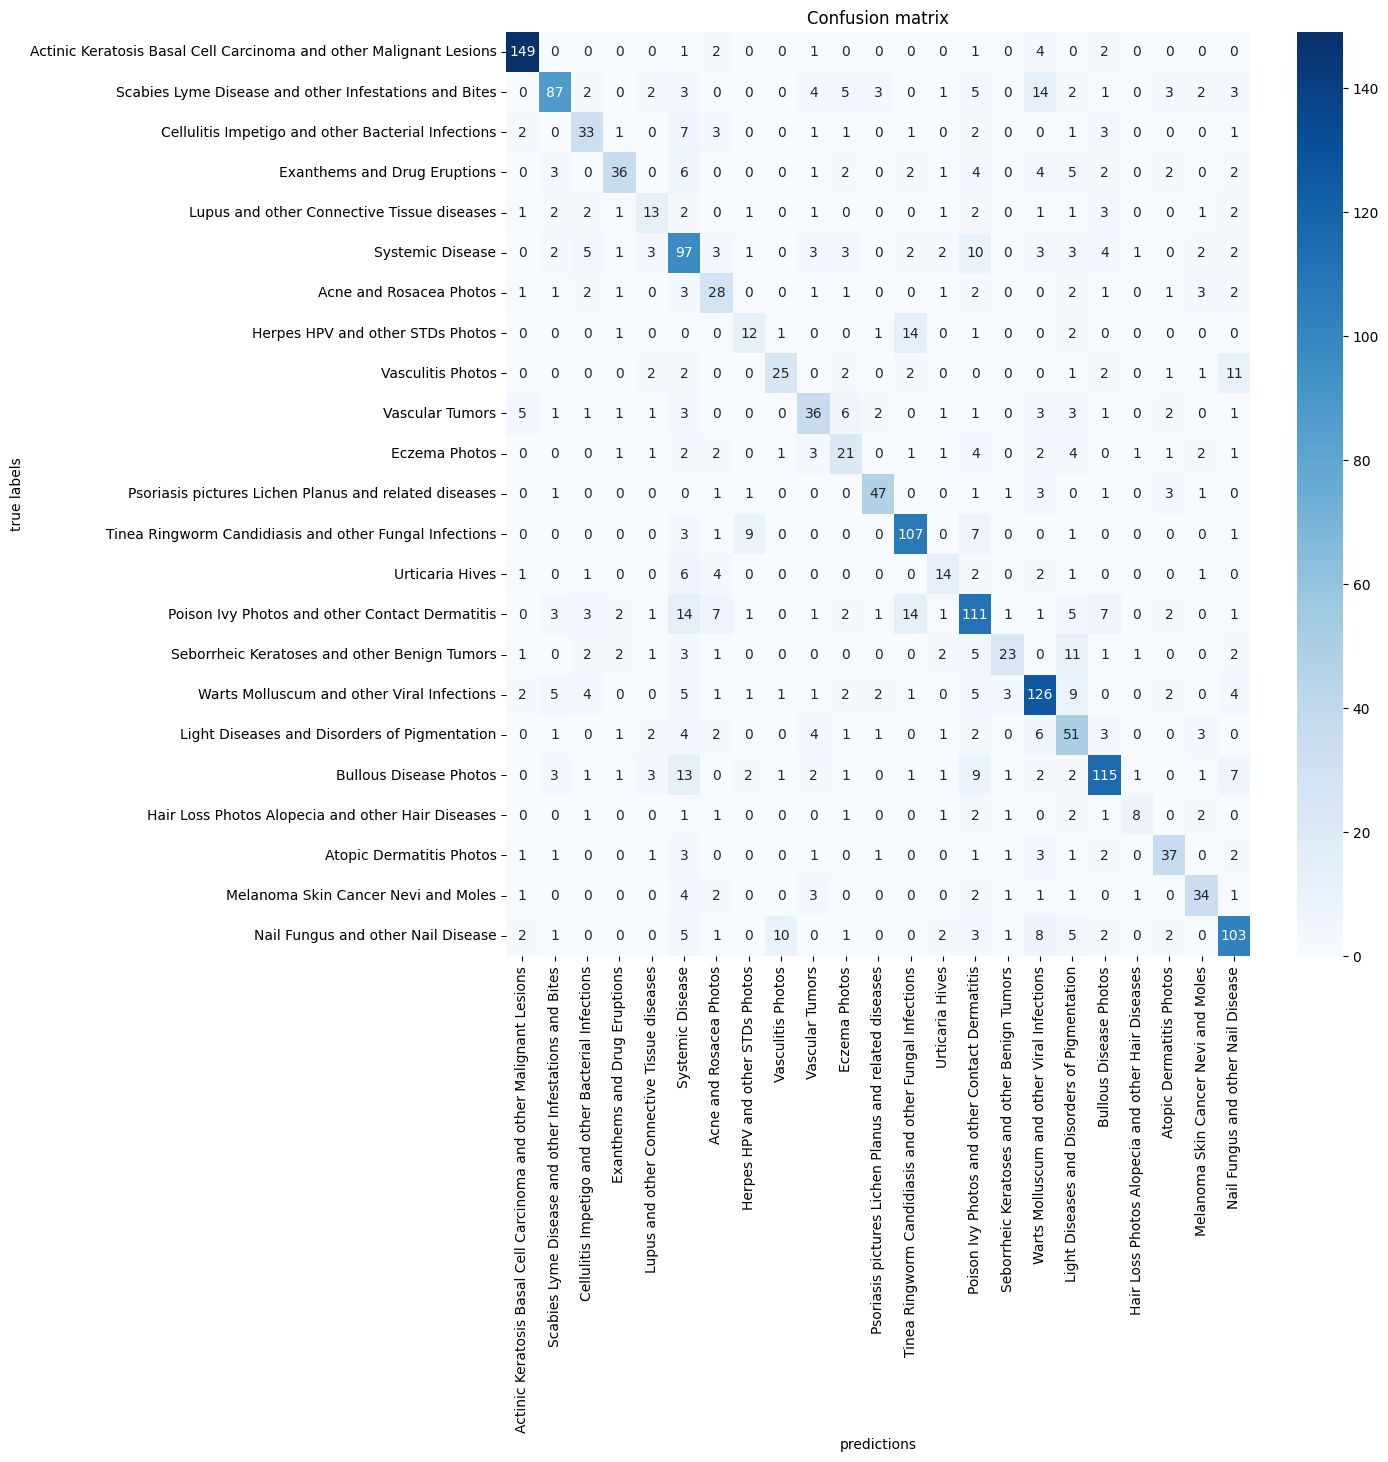

In [ ]:
efficientnet_v2_s_characteristics = train_and_show_results(models_list[1])

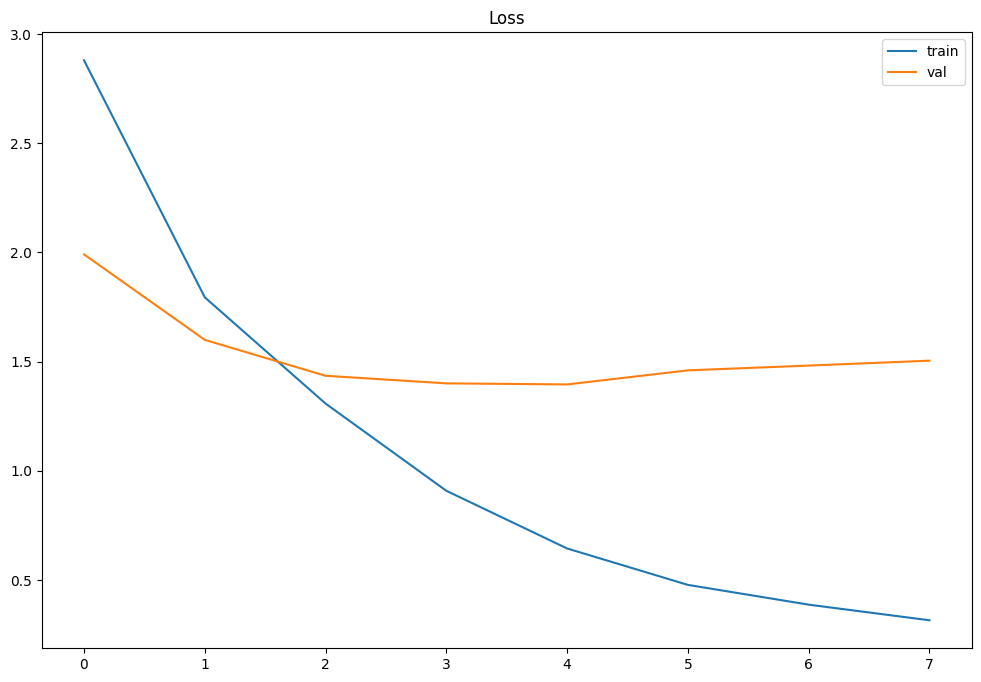

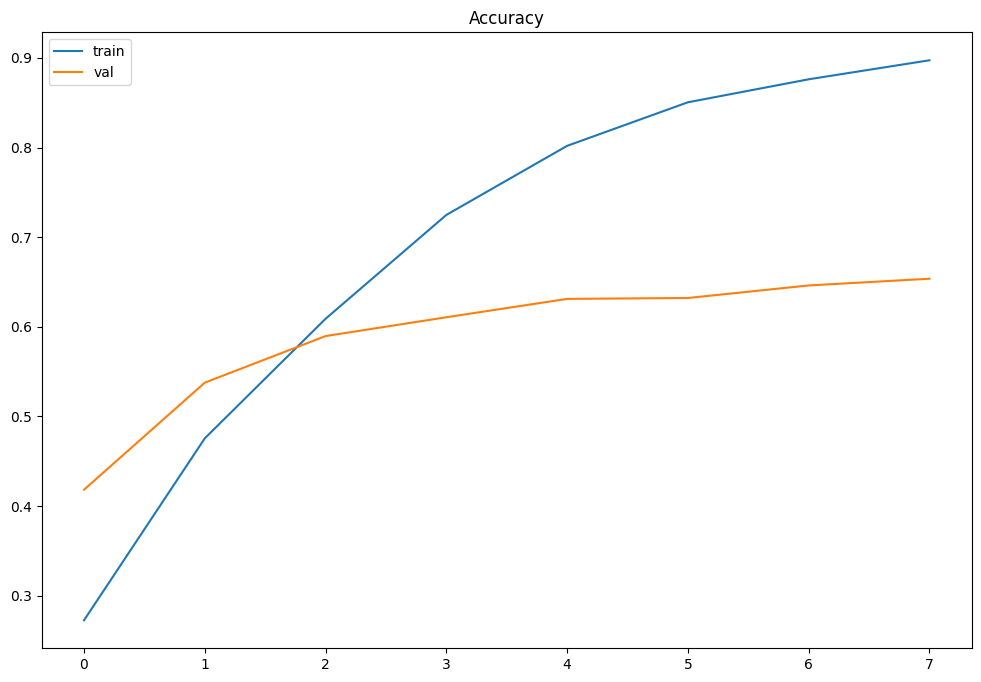

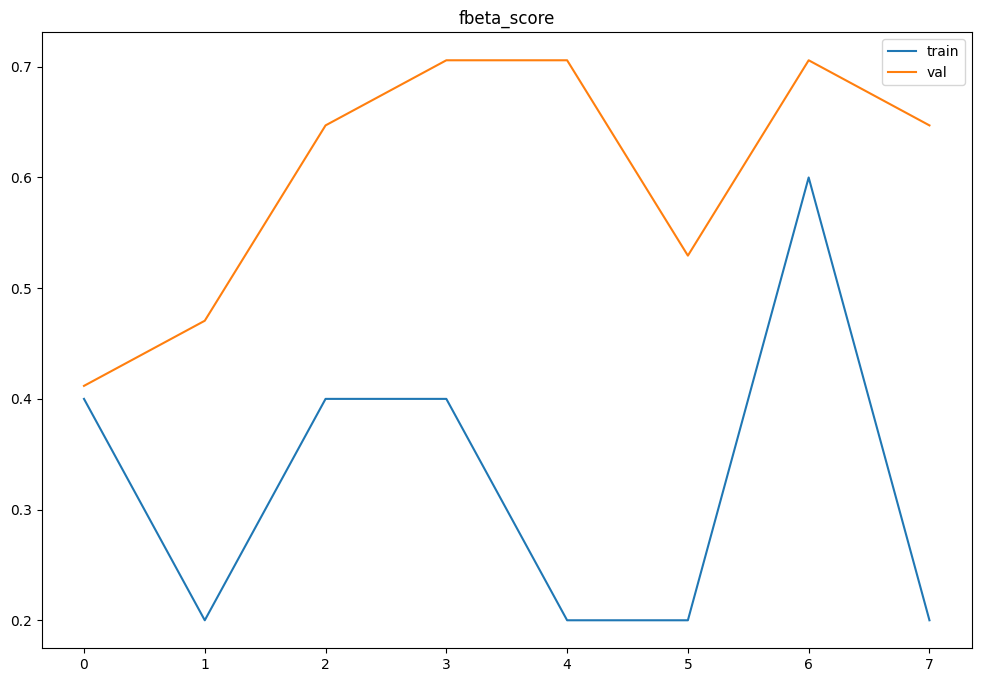

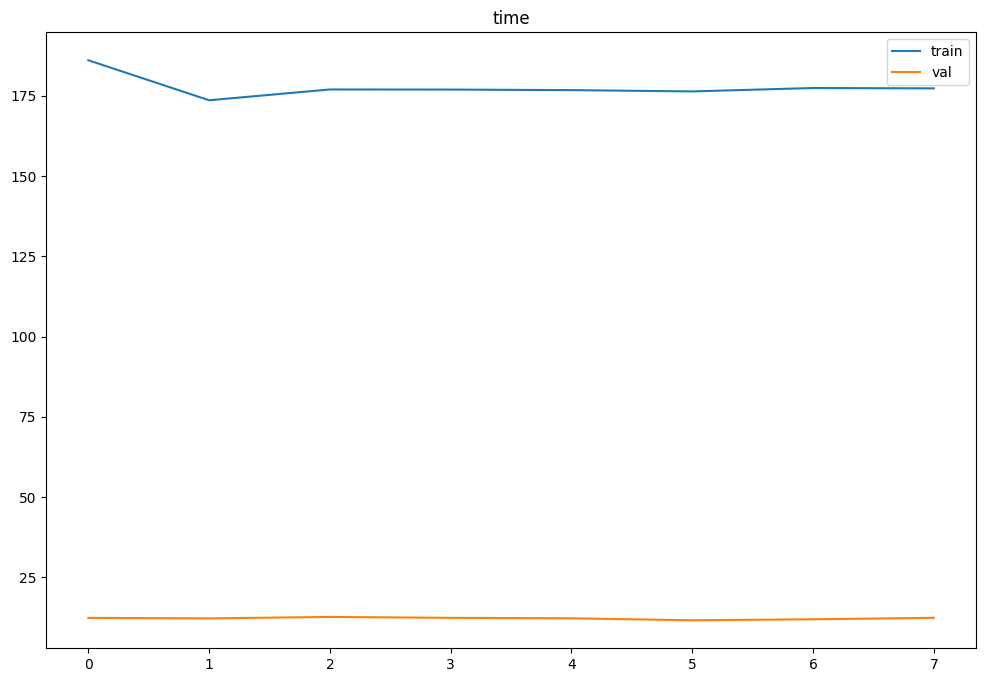

In [ ]:
show_metrics(efficientnet_v2_s_characteristics)

Epoch 0/7
----------
tensor([11, 17, 16, 20, 11], device='cuda:0')
tensor([14, 15, 16, 20, 18], device='cuda:0')
<class 'torch.Tensor'>
<class 'torch.Tensor'>
train Loss: 2.8583 Acc: 0.3015
tensor([ 9,  2,  5, 20, 13, 18, 18, 22,  3,  8,  5, 19, 11,  5,  5,  3,  3],
       device='cuda:0')
tensor([ 6, 14,  0,  0,  6, 18,  0, 22, 16, 21,  0, 18, 11, 14,  1, 18,  0],
       device='cuda:0')
<class 'torch.Tensor'>
<class 'torch.Tensor'>
val Loss: 2.0172 Acc: 0.4103

Epoch 1/7
----------
tensor([22, 15, 15, 22,  8], device='cuda:0')
tensor([16,  5, 19,  0, 14], device='cuda:0')
<class 'torch.Tensor'>
<class 'torch.Tensor'>
train Loss: 1.8089 Acc: 0.4679
tensor([ 9,  2,  5, 20, 13, 18, 18, 22,  3,  8,  5, 19, 11,  5,  5,  3,  3],
       device='cuda:0')
tensor([ 6,  2,  0, 16,  6, 18,  0, 22, 16, 22,  5, 18, 11, 14,  5, 18, 22],
       device='cuda:0')
<class 'torch.Tensor'>
<class 'torch.Tensor'>
val Loss: 1.7681 Acc: 0.4858

Epoch 2/7
----------
tensor([ 1,  8, 10, 14,  2], device='cuda:0

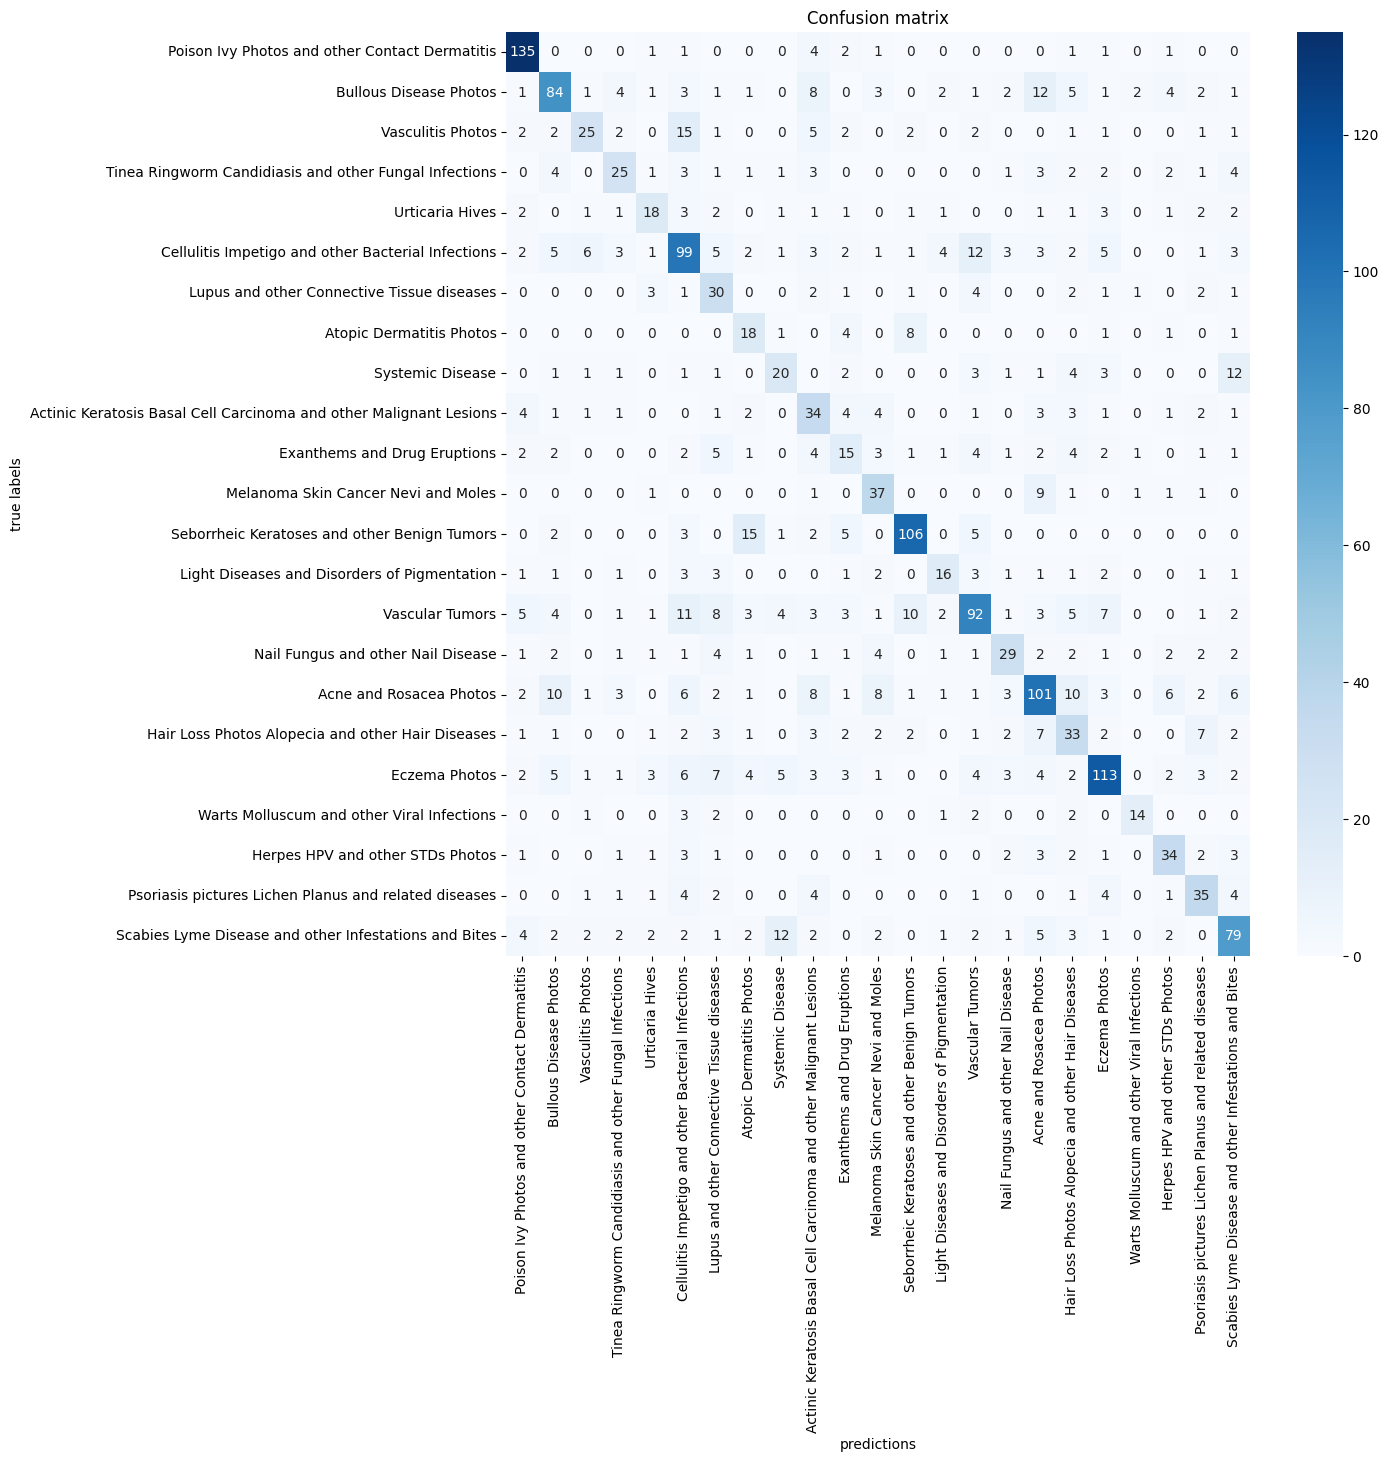

In [ ]:
densnet_characteristics = train_and_show_results(models_list[2])

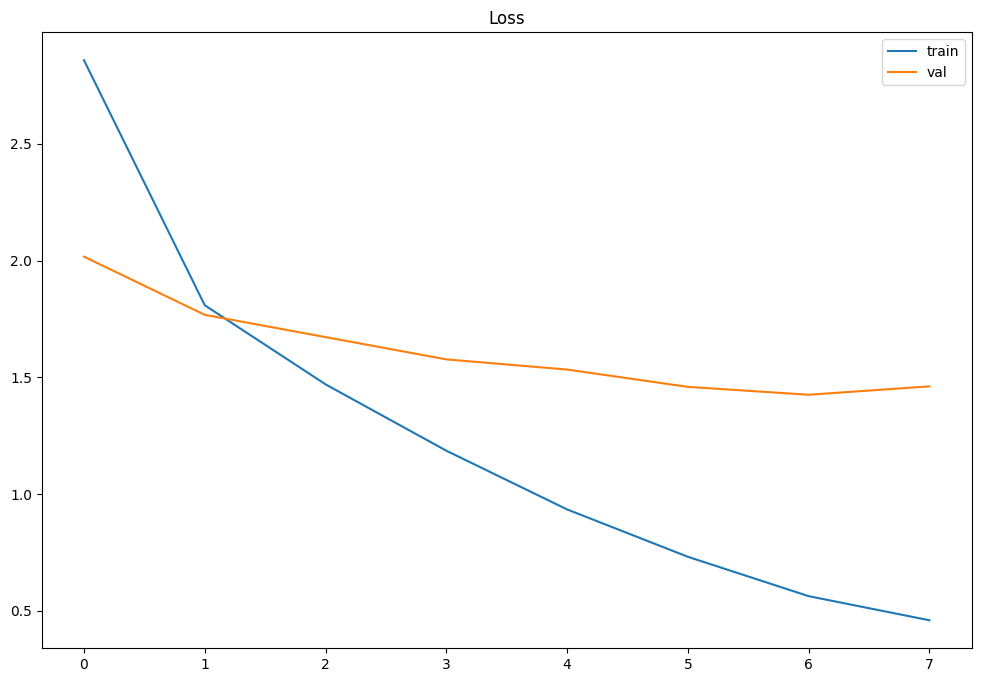

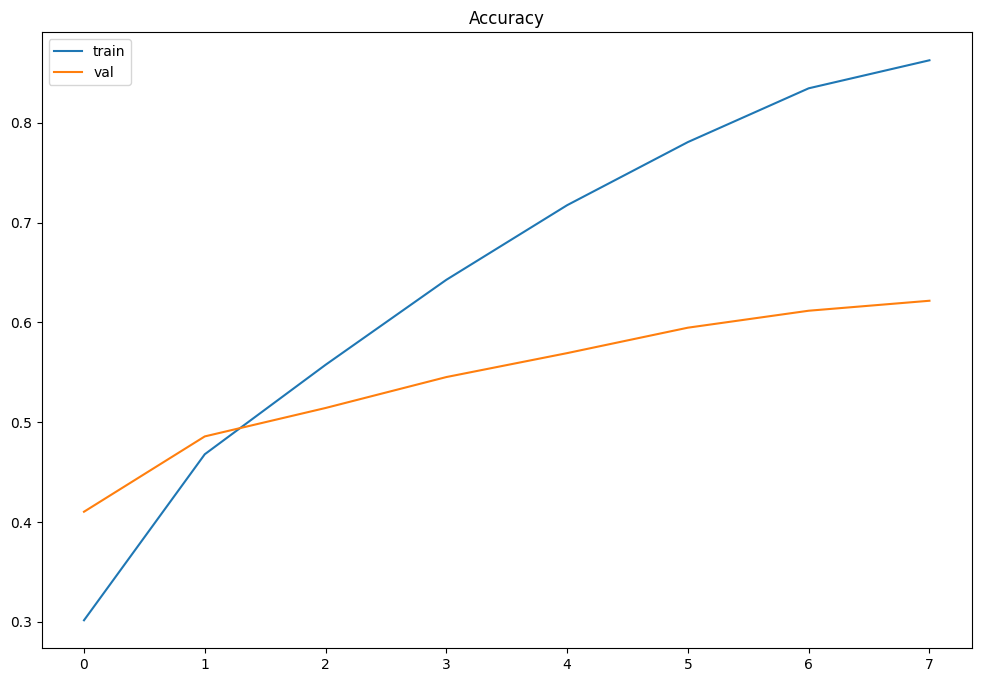

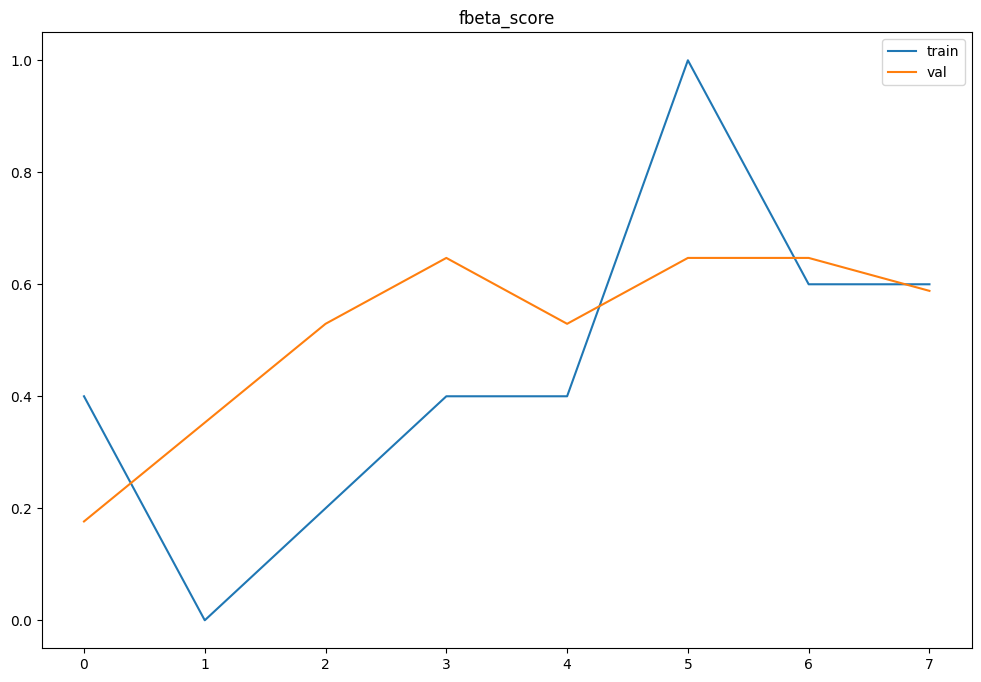

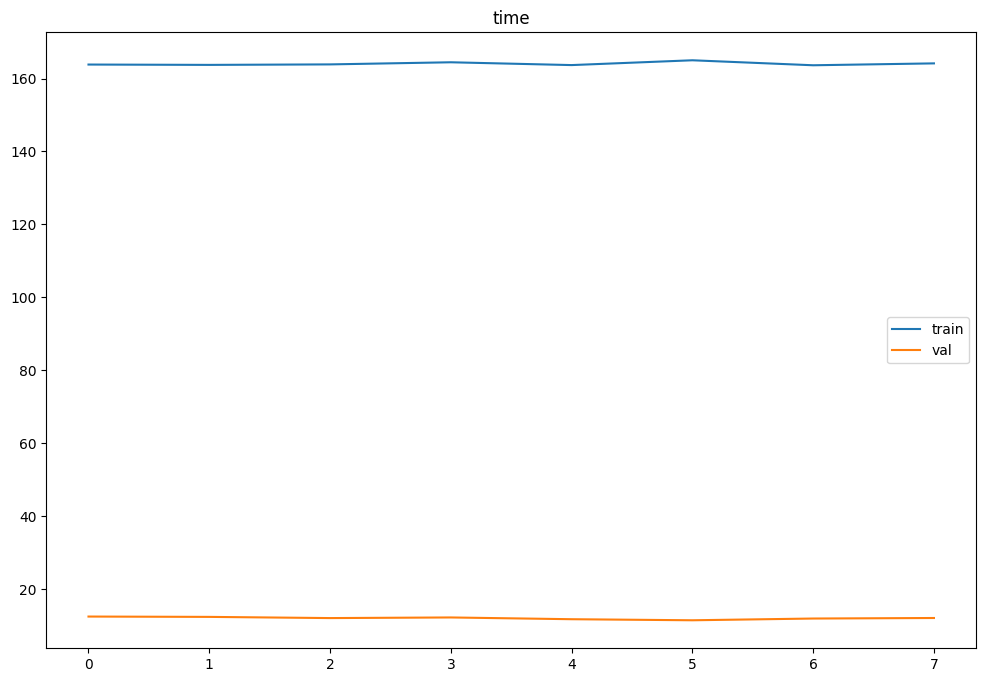

In [ ]:
show_metrics(densnet_characteristics)

Epoch 0/7
----------
tensor([14,  6, 14, 16, 14], device='cuda:0')
tensor([14,  6, 10, 16, 14], device='cuda:0')
<class 'torch.Tensor'>
<class 'torch.Tensor'>
train Loss: 0.5242 Acc: 0.8284
tensor([17, 16,  1,  0,  2,  0,  5,  2,  6,  1, 10, 14, 10, 10, 22,  1, 22],
       device='cuda:0')
tensor([14, 22,  1,  0,  2,  0,  5,  2, 21,  1, 10, 14, 10, 10, 22,  1,  5],
       device='cuda:0')
<class 'torch.Tensor'>
<class 'torch.Tensor'>
val Loss: 1.3229 Acc: 0.6777

Epoch 1/7
----------
tensor([ 3,  5, 13, 11, 17], device='cuda:0')
tensor([ 3,  5, 13, 11, 17], device='cuda:0')
<class 'torch.Tensor'>
<class 'torch.Tensor'>
train Loss: 0.4442 Acc: 0.8578
tensor([17, 16,  1,  0,  2,  0,  5,  2,  6,  1, 10, 14, 10, 10, 22,  1, 22],
       device='cuda:0')
tensor([16, 17, 16,  0,  2,  0,  5, 10, 22,  1, 10, 14, 10, 10, 22,  1,  5],
       device='cuda:0')
<class 'torch.Tensor'>
<class 'torch.Tensor'>
val Loss: 1.2827 Acc: 0.6822

Epoch 2/7
----------
tensor([16,  1, 14, 16, 18], device='cuda:0

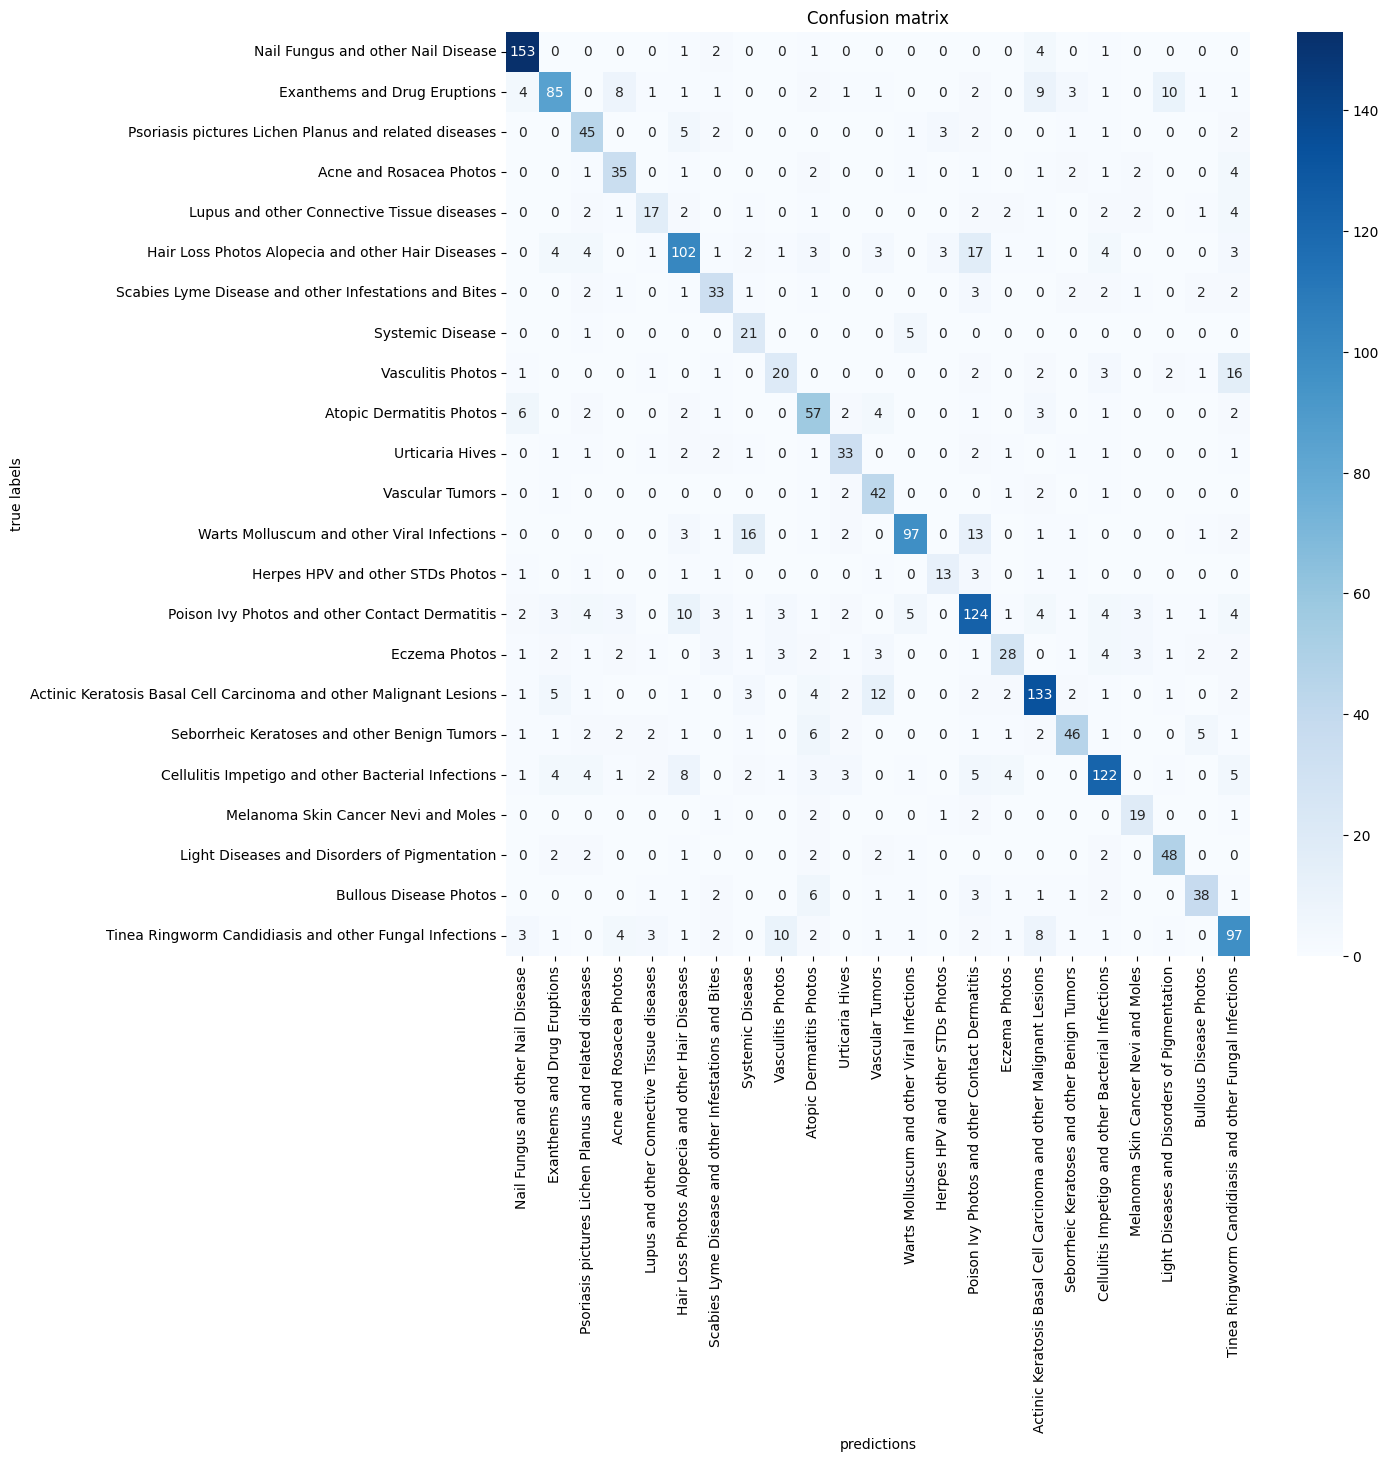

In [ ]:
swin_v2_t_characteristics = train_and_show_results(models_list[3])

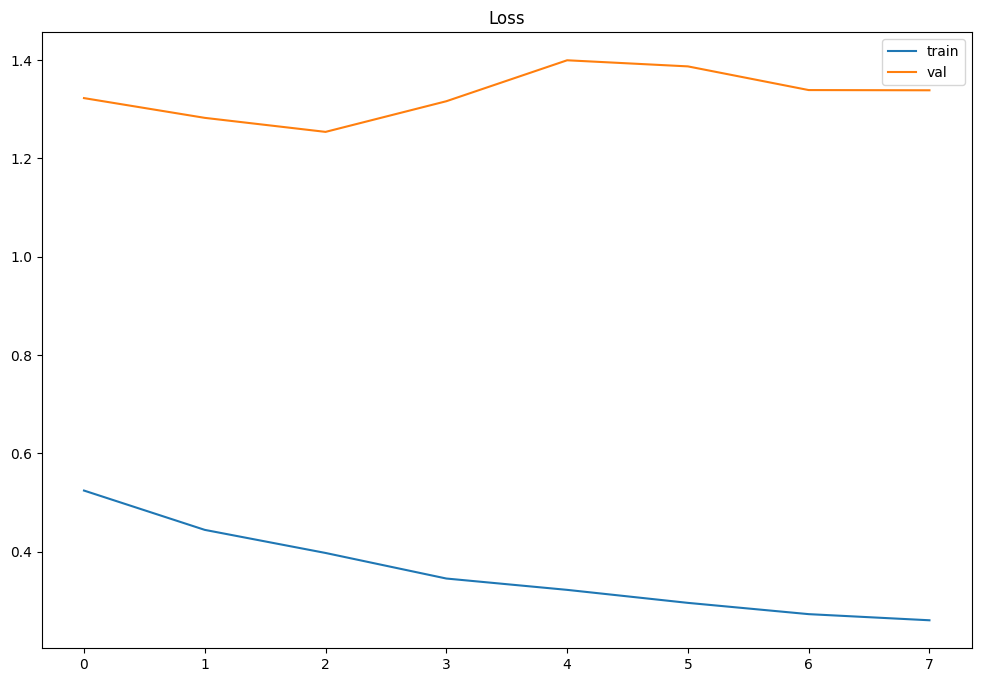

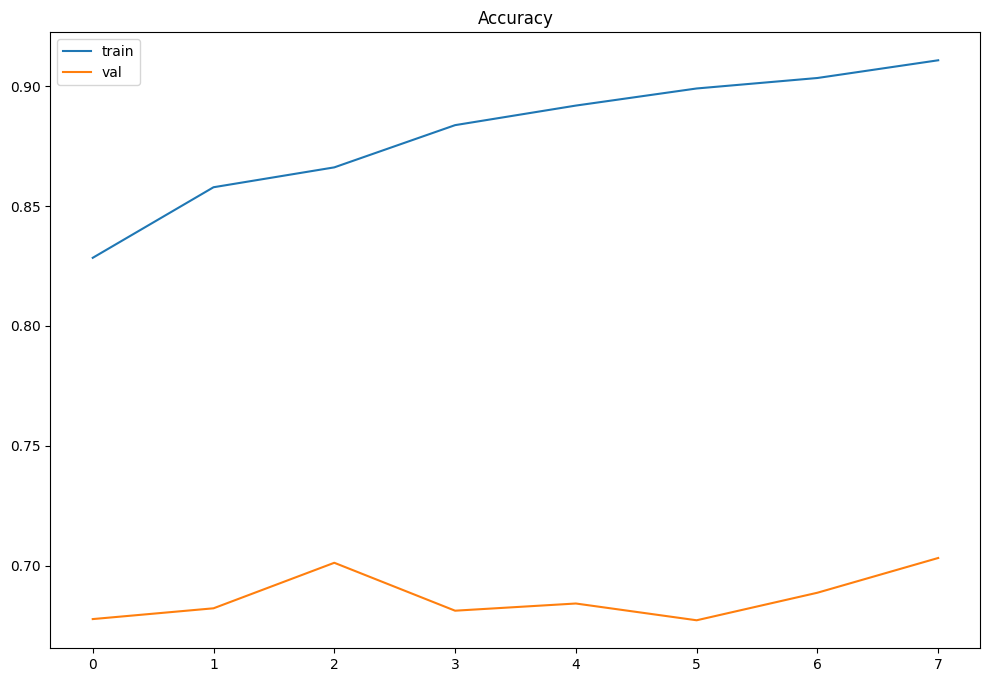

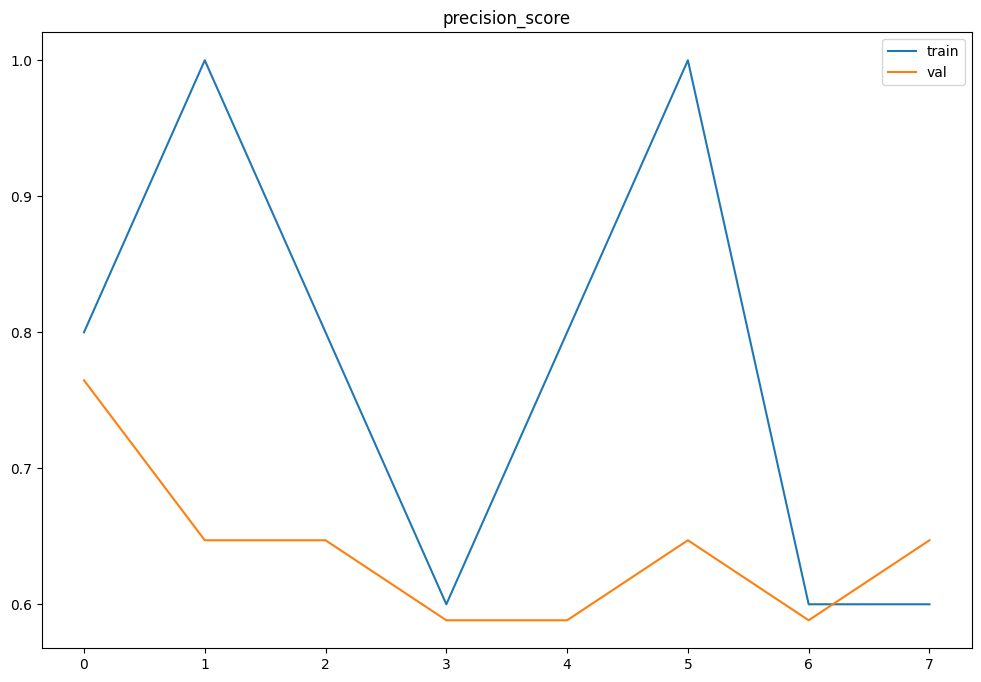

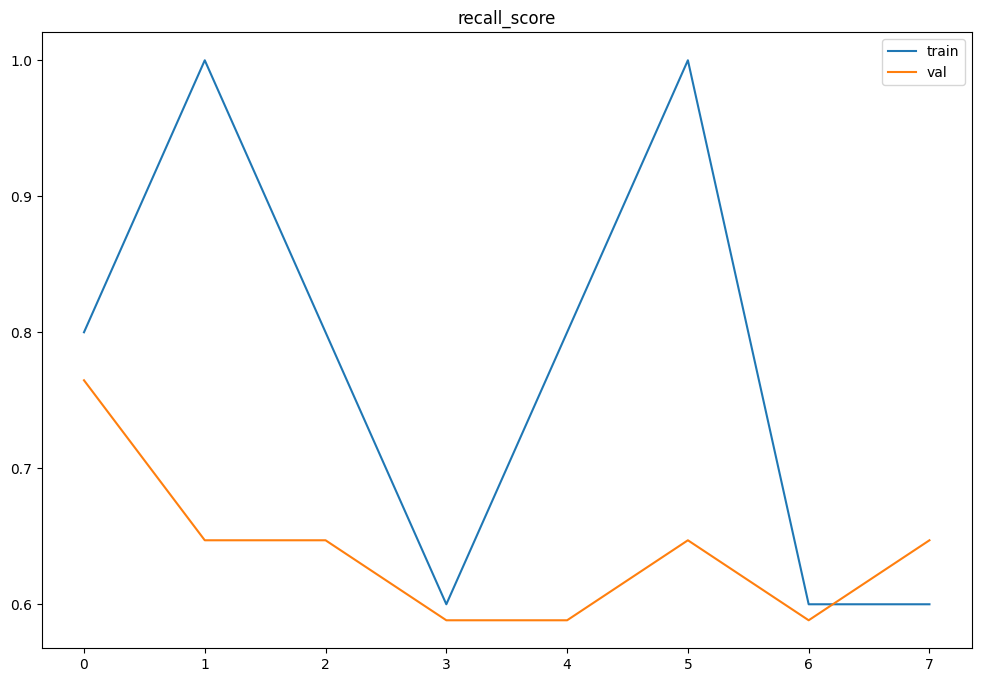

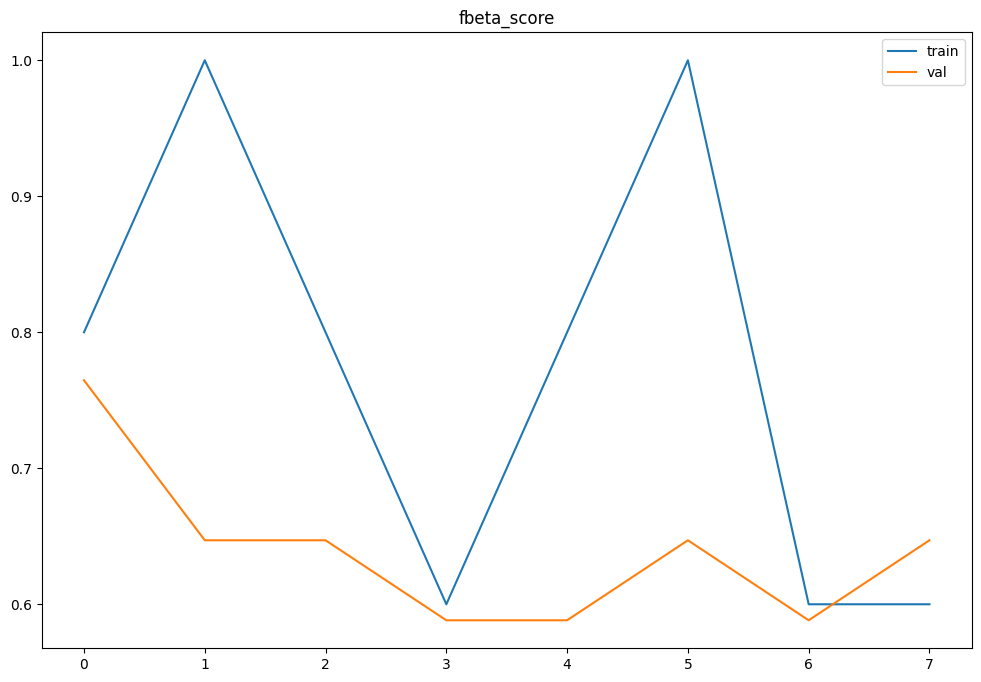

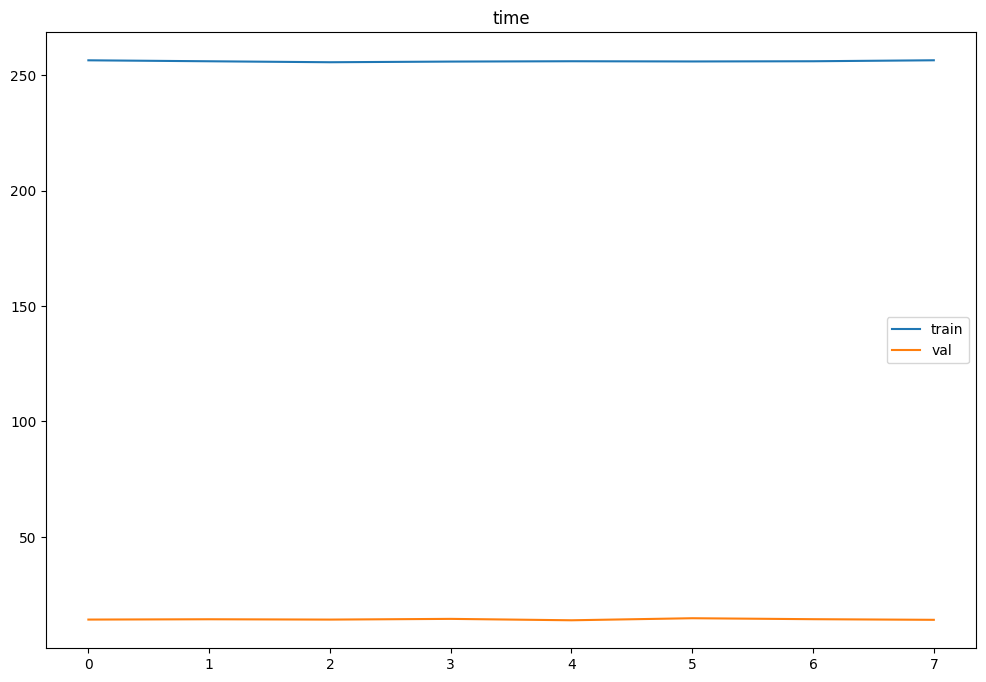

In [ ]:
show_metrics(swin_v2_t_characteristics)

Precision

Recall

TODO: Посчитать precision, recall, f2-score

# Сравнение результатов обучения

In [ ]:
def show_metric_models(models_characteristic, metric_name):
  plt.figure(figsize=(12, 8))
  for i in range(len(models_characteristic)):
    plt.plot(models_characteristic[i].metric_history, label=models_characteristic[i].model_name)
  plt.title(metric_name)
  # plt.xlabel()
  plt.legend()
  plt.show()

def show_metric_tensor_models(models_characteristic, metric_name):
  plt.figure(figsize=(12, 8))
  for i in range(len(models_characteristic)):
    plt.plot(tensor_list_to_list(models_characteristic[i].metric_history), label=models_characteristic[i].model_name)
  plt.title(metric_name)
  # plt.xlabel()
  plt.legend()
  plt.show()

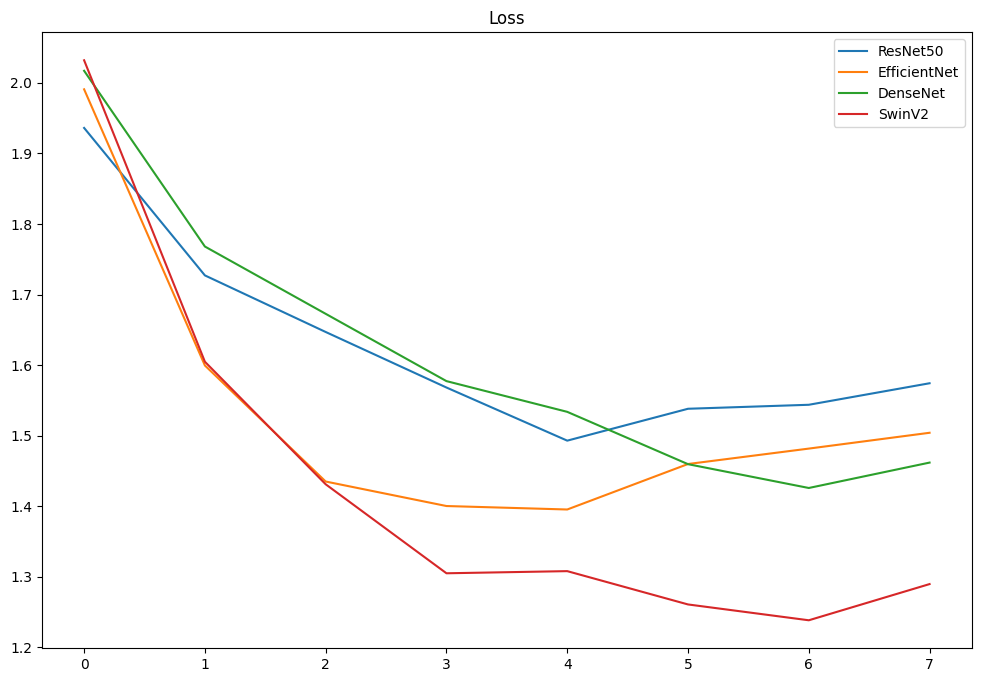

In [ ]:
ResNet50_Loss = []
for i in range(len(resnet50_characteristics.val_epoch_characteristics)):
  ResNet50_Loss.append(resnet50_characteristics.val_epoch_characteristics[i].loss)

ResNet50_loss_characteristic = Model_one_characteristic(metric_history = ResNet50_Loss, model_name = 'ResNet50')


EfficientNet_Loss = []
for i in range(len(efficientnet_v2_s_characteristics.val_epoch_characteristics)):
  EfficientNet_Loss.append(efficientnet_v2_s_characteristics.val_epoch_characteristics[i].loss)

EfficientNet_loss_characteristic = Model_one_characteristic(metric_history = EfficientNet_Loss, model_name = 'EfficientNet')

DenseNet_Loss = []
for i in range(len(densnet_characteristics.val_epoch_characteristics)):
  DenseNet_Loss.append(densnet_characteristics.val_epoch_characteristics[i].loss)

DenseNet_loss_characteristic = Model_one_characteristic(metric_history = DenseNet_Loss, model_name = 'DenseNet')

SwinV2_Loss = []
for i in range(len(swin_v2_t_characteristics.val_epoch_characteristics)):
  SwinV2_Loss.append(swin_v2_t_characteristics.val_epoch_characteristics[i].loss)

SwinV2_loss_characteristic = Model_one_characteristic(metric_history = SwinV2_Loss, model_name = 'SwinV2')


models = []
models.append(ResNet50_loss_characteristic)
models.append(EfficientNet_loss_characteristic)
models.append(DenseNet_loss_characteristic)
models.append(SwinV2_loss_characteristic)

show_metric_models(models, 'Loss')


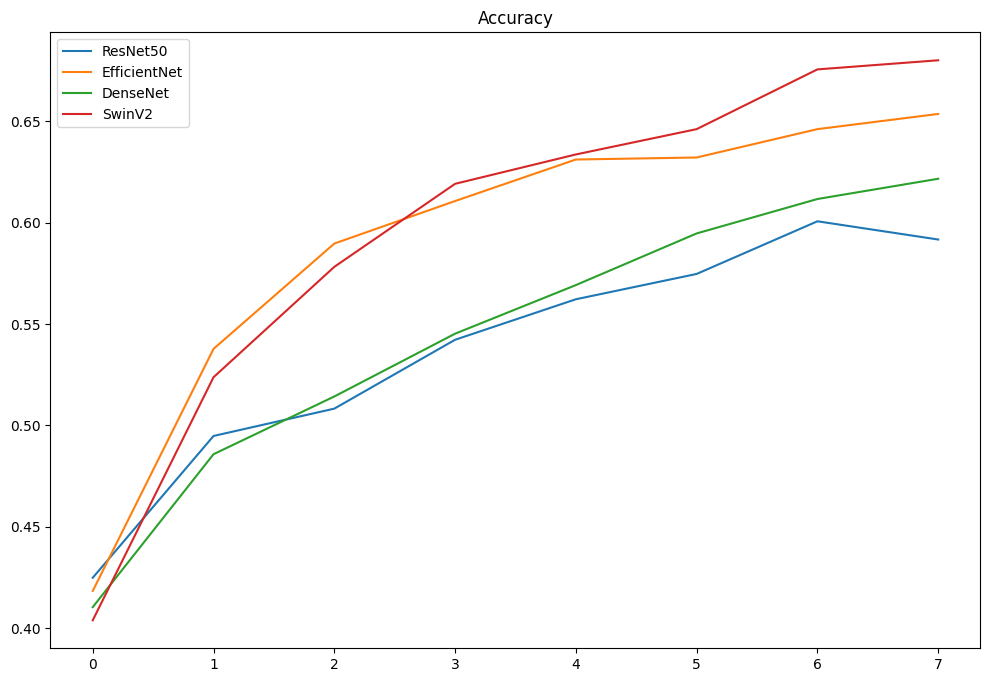

In [ ]:
ResNet50_Loss = []
for i in range(len(resnet50_characteristics.val_epoch_characteristics)):
  ResNet50_Loss.append(resnet50_characteristics.val_epoch_characteristics[i].accuracy)

ResNet50_loss_characteristic = Model_one_characteristic(metric_history = ResNet50_Loss, model_name = 'ResNet50')


EfficientNet_Loss = []
for i in range(len(efficientnet_v2_s_characteristics.val_epoch_characteristics)):
  EfficientNet_Loss.append(efficientnet_v2_s_characteristics.val_epoch_characteristics[i].accuracy)

EfficientNet_loss_characteristic = Model_one_characteristic(metric_history = EfficientNet_Loss, model_name = 'EfficientNet')

DenseNet_Loss = []
for i in range(len(densnet_characteristics.val_epoch_characteristics)):
  DenseNet_Loss.append(densnet_characteristics.val_epoch_characteristics[i].accuracy)

DenseNet_loss_characteristic = Model_one_characteristic(metric_history = DenseNet_Loss, model_name = 'DenseNet')

SwinV2_Loss = []
for i in range(len(swin_v2_t_characteristics.val_epoch_characteristics)):
  SwinV2_Loss.append(swin_v2_t_characteristics.val_epoch_characteristics[i].accuracy)

SwinV2_loss_characteristic = Model_one_characteristic(metric_history = SwinV2_Loss, model_name = 'SwinV2')


models = []
models.append(ResNet50_loss_characteristic)
models.append(EfficientNet_loss_characteristic)
models.append(DenseNet_loss_characteristic)
models.append(SwinV2_loss_characteristic)

show_metric_tensor_models(models, 'Accuracy')


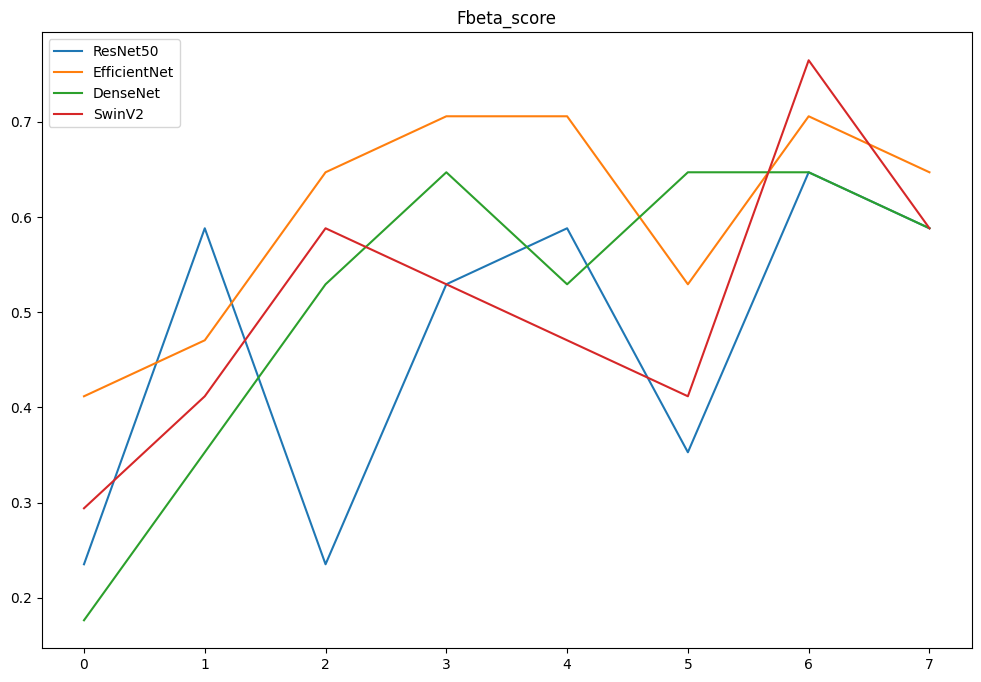

In [ ]:
ResNet50_Loss = []
for i in range(len(resnet50_characteristics.val_epoch_characteristics)):
  ResNet50_Loss.append(resnet50_characteristics.val_epoch_characteristics[i].fbeta_score)

ResNet50_loss_characteristic = Model_one_characteristic(metric_history = ResNet50_Loss, model_name = 'ResNet50')


EfficientNet_Loss = []
for i in range(len(efficientnet_v2_s_characteristics.val_epoch_characteristics)):
  EfficientNet_Loss.append(efficientnet_v2_s_characteristics.val_epoch_characteristics[i].fbeta_score)

EfficientNet_loss_characteristic = Model_one_characteristic(metric_history = EfficientNet_Loss, model_name = 'EfficientNet')

DenseNet_Loss = []
for i in range(len(densnet_characteristics.val_epoch_characteristics)):
  DenseNet_Loss.append(densnet_characteristics.val_epoch_characteristics[i].fbeta_score)

DenseNet_loss_characteristic = Model_one_characteristic(metric_history = DenseNet_Loss, model_name = 'DenseNet')

SwinV2_Loss = []
for i in range(len(swin_v2_t_characteristics.val_epoch_characteristics)):
  SwinV2_Loss.append(swin_v2_t_characteristics.val_epoch_characteristics[i].fbeta_score)

SwinV2_loss_characteristic = Model_one_characteristic(metric_history = SwinV2_Loss, model_name = 'SwinV2')


models = []
models.append(ResNet50_loss_characteristic)
models.append(EfficientNet_loss_characteristic)
models.append(DenseNet_loss_characteristic)
models.append(SwinV2_loss_characteristic)

show_metric_models(models, 'Fbeta_score')

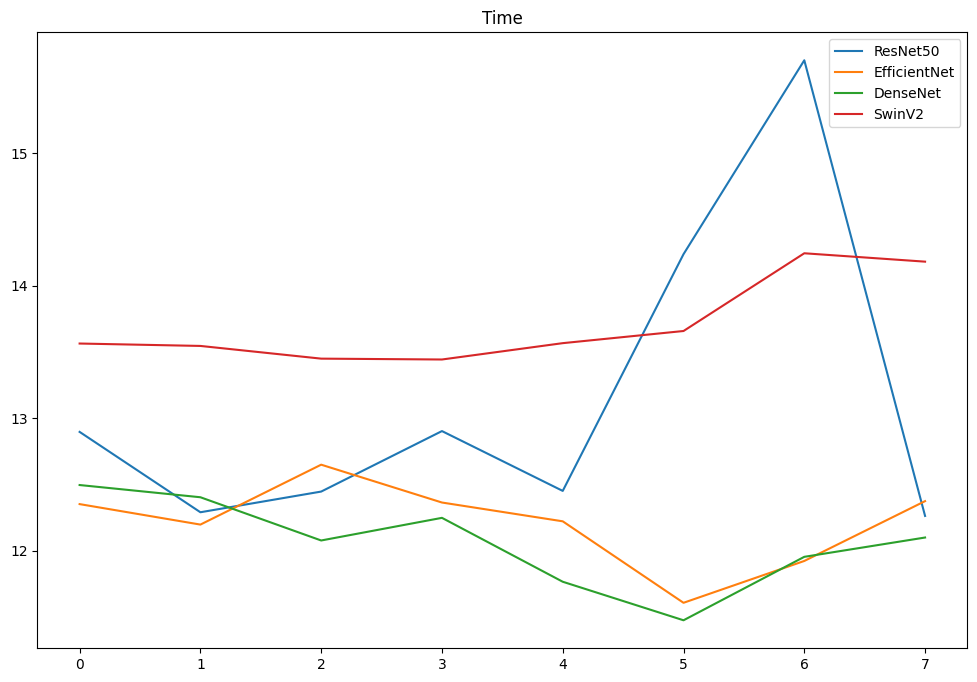

In [ ]:
ResNet50_Loss = []
for i in range(len(resnet50_characteristics.val_epoch_characteristics)):
  ResNet50_Loss.append(resnet50_characteristics.val_epoch_characteristics[i].time)

ResNet50_loss_characteristic = Model_one_characteristic(metric_history = ResNet50_Loss, model_name = 'ResNet50')


EfficientNet_Loss = []
for i in range(len(efficientnet_v2_s_characteristics.val_epoch_characteristics)):
  EfficientNet_Loss.append(efficientnet_v2_s_characteristics.val_epoch_characteristics[i].time)

EfficientNet_loss_characteristic = Model_one_characteristic(metric_history = EfficientNet_Loss, model_name = 'EfficientNet')

DenseNet_Loss = []
for i in range(len(densnet_characteristics.val_epoch_characteristics)):
  DenseNet_Loss.append(densnet_characteristics.val_epoch_characteristics[i].time)

DenseNet_loss_characteristic = Model_one_characteristic(metric_history = DenseNet_Loss, model_name = 'DenseNet')

SwinV2_Loss = []
for i in range(len(swin_v2_t_characteristics.val_epoch_characteristics)):
  SwinV2_Loss.append(swin_v2_t_characteristics.val_epoch_characteristics[i].time)

SwinV2_loss_characteristic = Model_one_characteristic(metric_history = SwinV2_Loss, model_name = 'SwinV2')


models = []
models.append(ResNet50_loss_characteristic)
models.append(EfficientNet_loss_characteristic)
models.append(DenseNet_loss_characteristic)
models.append(SwinV2_loss_characteristic)

show_metric_models(models, 'Time')

# **Сегментация области поражения**

In [ ]:
lesion_segmentation_model_path = deploma_root + '/MyProject/Models/LesionSegmentation/Unet2.pt'

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.pool0 = nn.MaxPool2d(kernel_size=2) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='nearest') # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest') # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        )

        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest')  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0_pool = self.pool0(e0)

        e1 = self.enc_conv1(e0_pool)
        e1_pool = self.pool1(e1)

        e2 = self.enc_conv2(e1_pool)
        e2_pool = self.pool2(e2)

        e3 = self.enc_conv3(e2_pool)
        e3_pool = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3_pool)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b), e3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), e2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), e1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), e0), dim=1))

        return d3

# Обучение модели

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import lr_scheduler
import tqdm
from time import time
import os

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(False)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [ ]:
!unzip -q drive/MyDrive/ReserveImportantDataCopy/MyProjects/DLS/HWs/HW6/Data/PH2Dataset.zip -d PH2Dataset

In [ ]:
images = []
lesions = []
# !ls PH2Dataset/PH2Dataset/PH2_Dataset
root = 'PH2Dataset/PH2Dataset/'
# for root, dirs, files in os.walk(os.path.join(root, 'PH2Dataset/')):
for root, dirs, files in os.walk('PH2Dataset/PH2Dataset/'):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

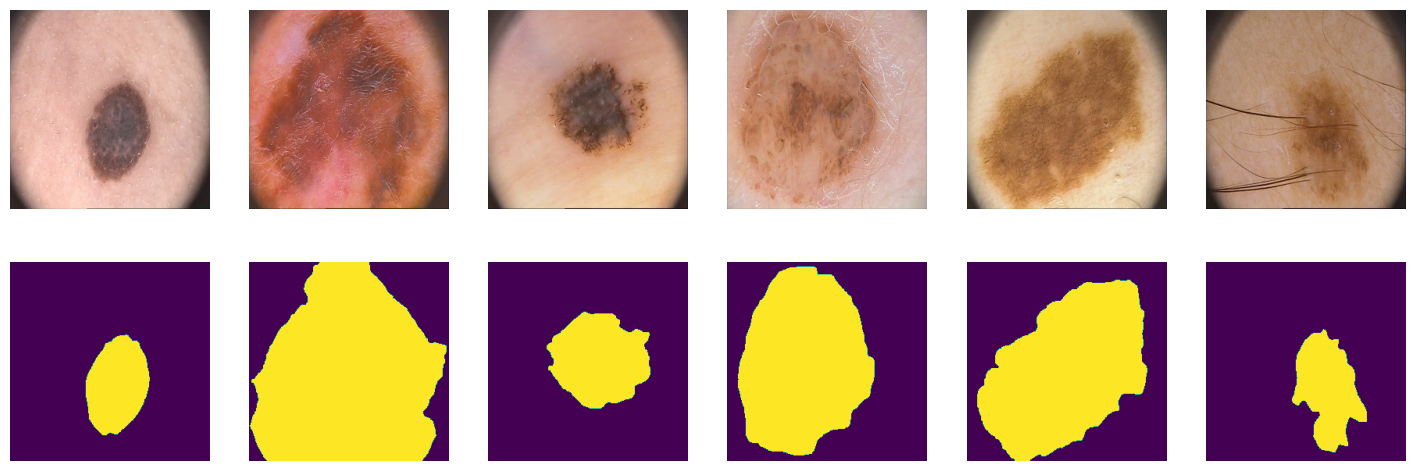

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
np.random.seed(42)

ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
for x_batch in data_tr:
  print(x_batch[0].shape)

torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])


In [ ]:
# for X_batch, Y_batch in data_val:

#   flatten = X_batch[0].flatten()
#   print(flatten.shape)
#   img = flatten.reshape(256,256,3)

#   plt.imshow(img, interpolation='nearest', cmap = 'gray')
#   plt.show()

In [ ]:
unet_model = UNet().to(device)

In [ ]:
gamma = 0.1
step_size = 6
lr = 1e-4

In [ ]:
def bce_loss(y_pred, y_real):
    return torch.mean(y_pred - y_pred * y_real + torch.log(1 + torch.exp( -y_pred)))

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler):
    history = {
        'train_loss':[],
        'val_loss':[],
        'train_score':[],
        'val_score':[]
    }
    
    best_acc = 0.0
    
    pbar = tqdm.trange(epochs, desc='Epochs') 
  
    for epoch in pbar:
        tic = time.time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        train_loss = 0
        val_loss = 0

        scheduler.step()
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)            

            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            train_loss += loss / len(data_tr)
        
        history['train_loss'].append(train_loss)
        epoch_train_score = score_model(model, iou_pytorch, data_tr)
        history['train_score'].append(epoch_train_score)

        toc = time.time()
        print('loss: %f' % train_loss)

        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
          for X_val, Y_val in data_val:
            
            # data to device
            X_val = X_val.to(device)
            Y_val = Y_val.to(device)

            print(type(X_val)) # torch Tensor
            print(X_val.shape) # 10 3 256 256 
            Y_pred = model(X_val)  
            loss = loss_fn(Y_pred, Y_val)

            val_loss += loss / len(data_val)
            
          history['val_loss'].append(val_loss)
          epoch_val_score = score_model(model, iou_pytorch, data_val)
          history['val_score'].append(epoch_val_score)

        
          Y_hat = Y_pred # model(X_val)

          # Visualize tools
          clear_output(wait=True)
          for k in range(6):
              plt.subplot(2, 6, k+1)
              plt.imshow(np.rollaxis(X_val[k].to('cpu').numpy(), 0, 3), cmap='gray')
              plt.title('Real')
              plt.axis('off')

              plt.subplot(2, 6, k+7)
              Y_hat = torch.where(torch.sigmoid(Y_hat)>0.5,1,0)
              plt.imshow(Y_hat[k, 0].to('cpu').numpy(), cmap='gray')
              plt.title('Output')
              plt.axis('off')
          plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, train_loss))
          plt.show()
            

        if epoch_val_score > best_acc:
            best_acc = epoch_val_score
            best_model_wts = model.state_dict()

        #pbar.set_description(f'{} Loss: {val_loss:.4f} Acc: {epoch_val_score:.4f}')

    return history

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        Y_pred = torch.sigmoid(Y_pred)
        
        scores += metric(Y_pred.round(), Y_label.to(device)).mean().item()

    return scores/len(data)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    # print("KEKEKE: ", outputs.sum(), outputs.dtype)
    # print("HEHEHE: ", labels.sum(), labels.dtype)
    SMOOTH = 1e-8
    intersection = (outputs.detach() & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    return iou  # 

In [ ]:
def tensor_list_to_list(tensor_list):
  result_list = []
  for i in tensor_list:
    result_list.append(i.cpu().detach())
  return result_list
  
def show_metric_tensor(tensor_list_train, tensor_list_val):
  plt.figure(figsize=(12, 8))
  plt.plot(tensor_list_to_list(tensor_list_train), label="train")
  plt.plot(tensor_list_to_list(tensor_list_val), label="val")
  plt.legend()
  plt.show()

def show_metric(tensor_list_train, tensor_list_val):
  plt.figure(figsize=(12, 8))
  plt.plot(tensor_list_train, label="train")
  plt.plot(tensor_list_val, label="val")
  plt.legend()
  plt.show()

def show_metrics(losses):
  show_metric_tensor(losses['train_loss'], losses['val_loss'])
  show_metric(losses['train_score'], losses['val_score'])

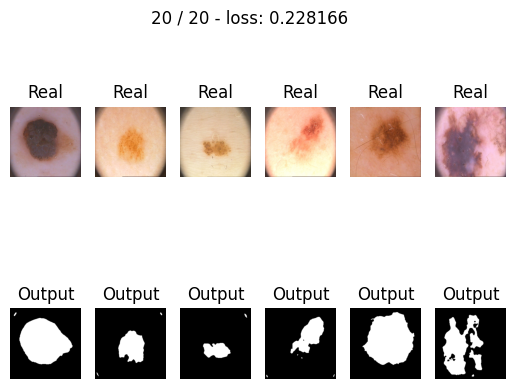

Epochs: 100%|██████████| 20/20 [02:43<00:00,  8.18s/it]


In [ ]:
max_epochs = 20
optimaizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimaizer, step_size=step_size, gamma=0.15)
losses_unet_focal = train(unet_model, optimaizer, bce_loss, max_epochs, data_tr, data_val, exp_lr_scheduler)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.7326003193855286

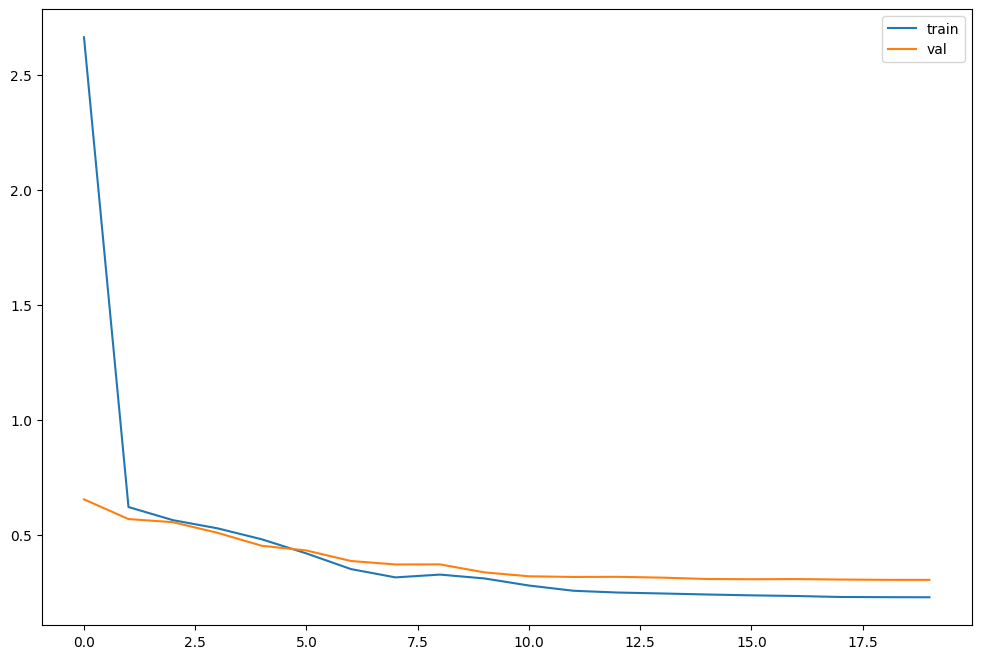

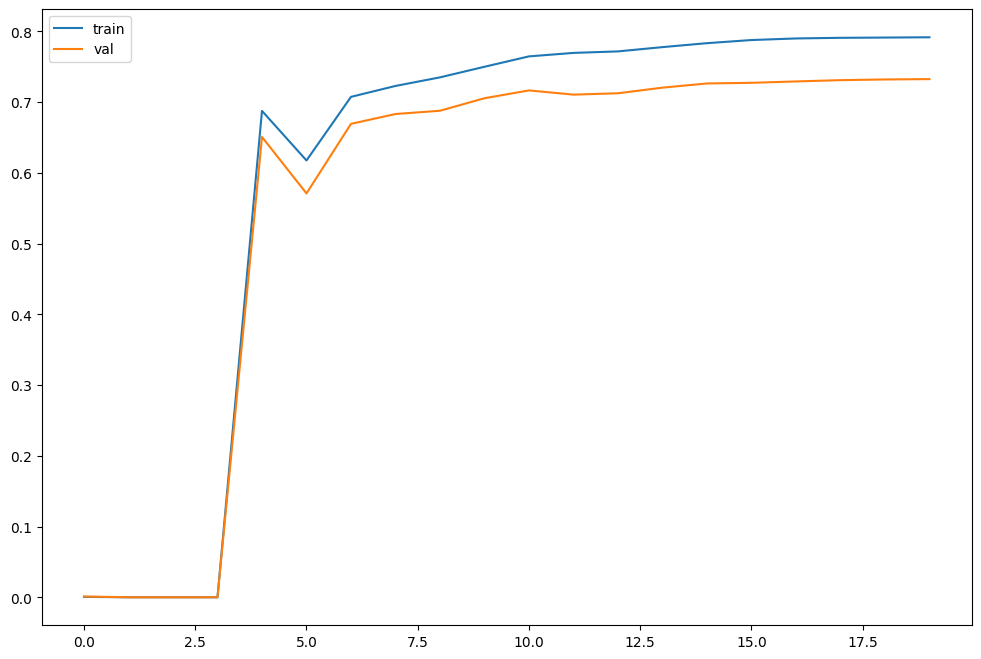

In [ ]:
show_metrics(losses_unet_focal)

In [ ]:
type(unet_model)

__main__.UNet

In [ ]:
# torch.save(unet_model, lesion_segmentation_model_path) 
torch.save(unet_model.state_dict(), lesion_segmentation_model_path)


# Загрузка и проверка работы модели

In [ ]:
# import __main__
# setattr(__main__, "UNet", "UNet")
# model = torch.load(lesion_segmentation_model_path, map_location=torch.device("cuda"))

In [ ]:
# model = torch.load(lesion_segmentation_model_path)
m_state_dict = torch.load(lesion_segmentation_model_path, map_location=(device))
model = UNet().to(device)
# unet_model = UNet().to(device)
model.load_state_dict(m_state_dict)


<All keys matched successfully>

In [ ]:
# # Save
# torch.save(net.state_dict(), PATH)

# # Load
# device = torch.device('cpu')
# model = Net()
# model.load_state_dict(torch.load(PATH, map_location=device))

In [ ]:
model.eval()
None

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    # Y_pred = [model(X_batch) for X_batch, _ in data]
    Y_pred = [model(X_batch) for X_batch in data]
    # Y_pred = model(data[0]) 
    return np.array(Y_pred)

In [ ]:
# data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
#                       batch_size=batch_size, shuffle=True)

In [ ]:
# %matplotlib inline 
# import matplotlib.pyplot as plt
# from IPython.display import clear_output

# plt.figure(figsize=(18, 6))
# for i in range(6):
#     plt.subplot(2, 6, i+1)
#     plt.axis("off")
#     plt.imshow(X[i])

#     plt.subplot(2, 6, i+7)
#     plt.axis("off")
#     plt.imshow(Y[i])
# plt.show();

In [ ]:
def show_before_after (model, data):  
  model.eval()  # testing mode
  with torch.no_grad():
    for X_val, Y_val in data:
      
      # data to device
      X_val = X_val.to(device)
      Y_val = Y_val.to(device)
      
      print(X_val.shape)
      print(X_val.size())
      print(X_val[0,:,:,:].shape)
      print(X_val[0,:,:,:].size())
      Y_pred = model(X_val)  
      
      Y_hat = Y_pred # model(X_val)
      # plt.imshow((Y_pred.cpu())[0][0])
      plt.imshow(np.rollaxis(X_val[0].to('cpu').numpy(), 0, 3))
      plt.show()

      Y_hat = torch.where(torch.sigmoid(Y_hat)>0.5,1,0)
      plt.imshow(Y_hat[0, 0].to('cpu').numpy(), cmap='gray')
      plt.show()
      
      return Y_hat[0, 0].to('cpu').numpy()

In [ ]:
from torch.utils.data import DataLoader
from skimage.transform import resize

def show_predict_lesion_segmentation(model, image_path):
  images = []
  lesions = []
  # image_path = 'MyProject/Data/Images/mole_pores2.jpg'
  for i in range(6):
    images.append(imread(os.path.join(deploma_root, image_path)))
    lesions.append(imread(os.path.join(deploma_root, image_path)))

  size = (256, 256)
  X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
  Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

  # X = images
  # Y = images

  X = np.array(X, np.float32)
  Y = np.array(Y, np.float32)
  print(f'Loaded {len(X)} images')

  len(lesions)

  np.random.seed(seed)

  ix = np.random.choice(len(X), len(X), False)
  tr, val, ts = np.split(ix, [2, 4])

  print(len(tr), len(val), len(ts))

  batch_size = 10
  data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                        batch_size=batch_size, shuffle=True)


  tensor = torch.from_numpy(X[0])

  return show_before_after(model, data_val)

Loaded 6 images
2 2 2
torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


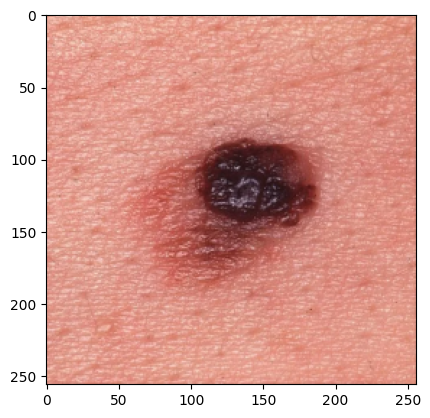

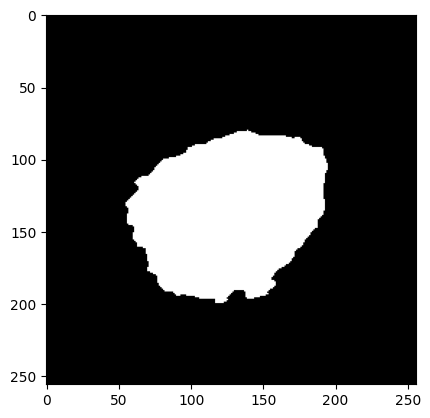

<class 'numpy.ndarray'>
(256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
bw_lesion = show_predict_lesion_segmentation(model, 'MyProject/Data/Images/mole_pores2.jpg')
print(type(bw_lesion))
print(bw_lesion.shape)
print(bw_lesion)

In [ ]:
def bw_01_to_bool (bw_lesion):
  bw_lesion_list = bw_lesion.tolist()
  for i in range(len(bw_lesion_list)):
    for j in range(len(bw_lesion_list[i])):
      if bw_lesion_list[i][j] == 0:
        bw_lesion_list[i][j] = False
      else:
        bw_lesion_list[i][j] = True
  return np.array(bw_lesion_list)


In [ ]:
print(bw_lesion)
lesion_bw = bw_01_to_bool(bw_lesion)
print(lesion_bw)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [ ]:
def lesion_subtraction (full_image, lesion_image):
  full_image = full_image.tolist()
  lesion_image = lesion_image.tolist()
  for i in range(len(full_image)):
    for j in range(len(full_image[i])):
      if full_image[i][j] == True and lesion_image[i][j] == True:
        full_image[i][j] = False
  return np.array(full_image)

# **Выделение рисунка на коже**







#  Попытка через переписывание кода MATLAB

In [ ]:
image_path = 'MyProject/Data/Images/mole_pores2.jpg'

In [ ]:
def CLAHE_to_image (image):
  bgr = image

  lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)

  lab_planes = cv2.split(lab)
  clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))

  lab_planes = list(lab_planes)

  lab_planes[0] = clahe.apply(lab_planes[0])

  lab = cv2.merge(lab_planes)

  bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

  print(bgr.shape)

  size = (256, 256)
  bgr = resize(bgr, size, mode='constant', anti_aliasing=True)
  return bgr

In [ ]:
def thinning(bw):
  square_parameters = [2]
  bw_thinned = 0
  for i in range(len(square_parameters)):
    bw_thinned = binary_erosion(bw, footprint=np.ones((square_parameters[i], square_parameters[i])))
  return bw_thinned

In [ ]:
def make_bw_image (image_path):
  readed_image = imread(os.path.join(deploma_root, image_path))

  size = (256, 256)
  image = resize(readed_image, size, mode='constant', anti_aliasing=True)

  %matplotlib inline 
  print(image.shape)
  plt.imshow(image, interpolation='nearest')
  plt.show()

  # Синий канал
  gray_image = image[:,:,2] 
  plt.imshow(gray_image, interpolation='nearest', cmap = 'gray')
  plt.show()

  bgr = CLAHE_to_image(readed_image)
  # bgr = CLAHE_to_image(gray_image)
  plt.imshow(bgr, interpolation='nearest', cmap = 'gray')
  plt.show()

  threshold = 0.25 # 0.
  bw = bgr < threshold
  plt.imshow(bw[:,:,2], interpolation='nearest', cmap = 'gray')
  plt.show()
  return bw[:,:,2]

(256, 256, 3)


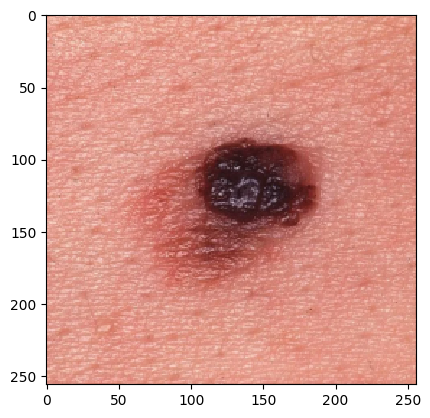

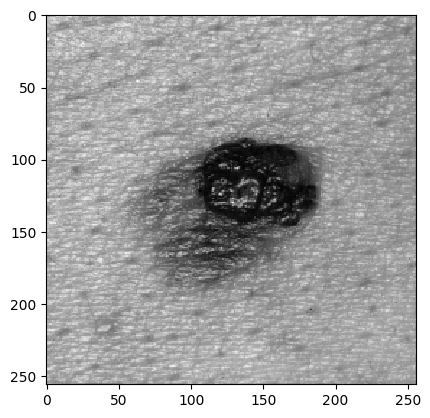

(564, 760, 3)


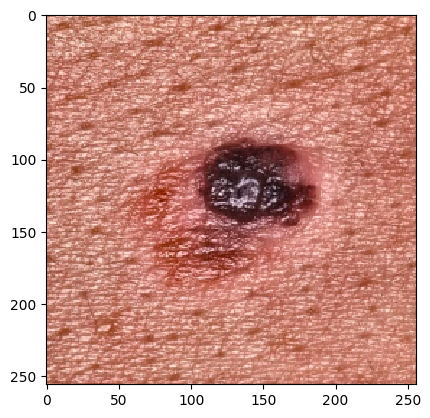

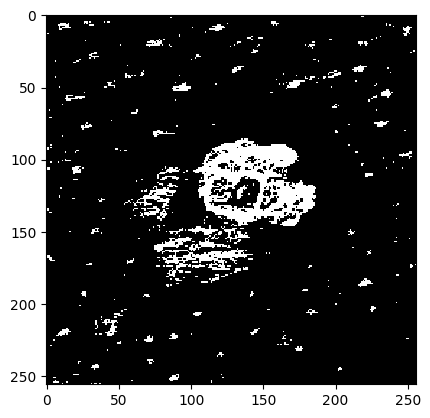

In [ ]:
bw = make_bw_image(image_path)

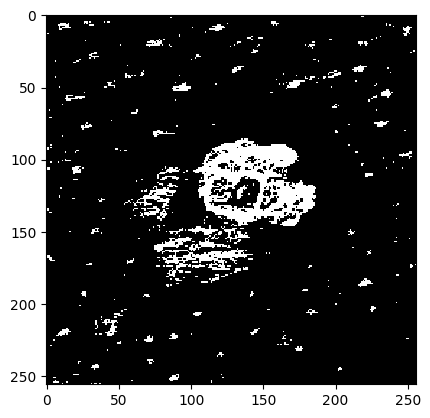

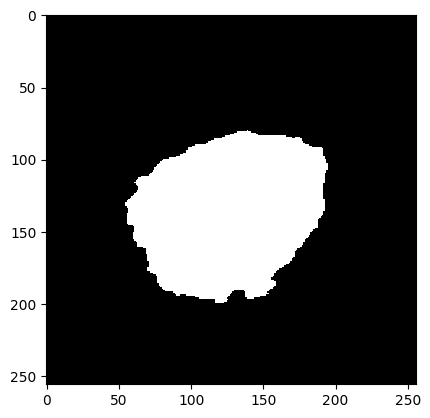

<class 'numpy.ndarray'>
(256, 256)
<class 'numpy.ndarray'>
(256, 256)


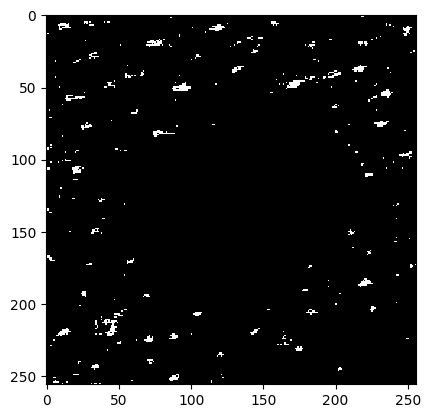

In [ ]:
plt.imshow(bw, interpolation='nearest', cmap = 'gray')
plt.show()
plt.imshow(lesion_bw, interpolation='nearest', cmap = 'gray')
plt.show()
print(type(bw))
print(bw.shape)
print(type(lesion_bw))
print(lesion_bw.shape)
bw_without_lesion = lesion_subtraction(bw, lesion_bw)
plt.imshow(bw_without_lesion, interpolation='nearest', cmap = 'gray')
plt.show()

In [ ]:
from skimage.measure import label, regionprops

def count_regions (colored):
  # Подсчет участков
  # label_img = label(colored)
  print('colored')
  print(type(colored))
  print(colored.shape)
  print(colored)

  label_img = label(colored)
  regions = regionprops(label_img)
  region_numbers = len(regions)
  print('Кол-во регионов = ' + str(region_numbers))


  # print('colored[:,:,0]')
  # print(type(colored[:,:,0]))
  # print(colored[:,:,0].shape)
  # print(colored[:,:,0])

  # label_img = label(colored[:,:,0])
  # regions = regionprops(label_img)
  # region_numbers = len(regions)
  # print('Кол-во регионов = ' + str(region_numbers))
  return region_numbers
  # for i in range(region_numbers):
  #   print(regions[i].bbox)

In [ ]:
def thinning_and_count_regions(bw):
  plt.imshow(bw, interpolation='nearest', cmap = 'gray')
  plt.show()

  bw_thinned = thinning(bw)
  plt.imshow(bw_thinned, interpolation='nearest', cmap = 'gray')
  plt.show()


  readed_image = imread(os.path.join(deploma_root, image_path))
  size = (256, 256)
  image = resize(readed_image, size, mode='constant', anti_aliasing=True)
  %matplotlib inline 
  print(image.shape)

  colored = label2rgb(label = bw_thinned, image = image, colors = ['red','green','magenta','blue','cyan'], kind = 'overlay', alpha = 0.6)
  # coloredLabels = label2rgb(label = bw_thinned, image = image, bg_color=(0, 0, 0), alpha=0.5, image_order='shuffle')
  plt.imshow(colored, interpolation='nearest')
  plt.show()

  return count_regions(bw_thinned)

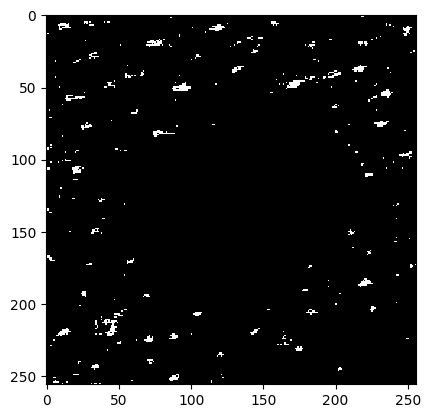

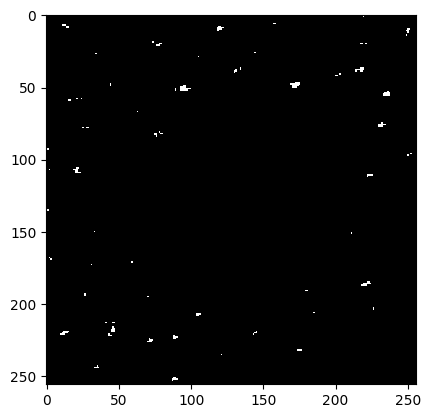

(256, 256, 3)


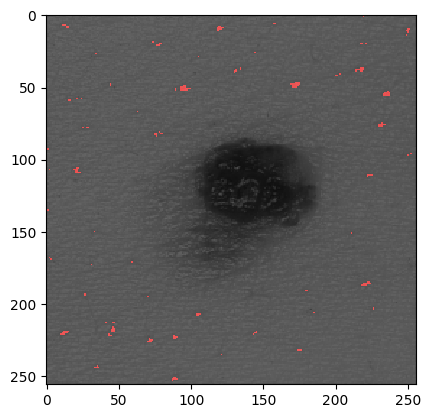

colored
<class 'numpy.ndarray'>
(256, 256)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Кол-во регионов = 66


66

In [ ]:
thinning_and_count_regions(bw_without_lesion)

In [ ]:
from skimage.morphology import binary_erosion
from skimage.color import label2rgb
# skimage.color.label2rgb()
def count_pores (image_path):

  bw = make_bw_image(image_path)


  # square_parameter1 = 3 # 17

  bw_thinned = thinning(bw)
  plt.imshow(bw_thinned, interpolation='nearest', cmap = 'gray')
  plt.show()


  readed_image = imread(os.path.join(deploma_root, image_path))
  size = (256, 256)
  image = resize(readed_image, size, mode='constant', anti_aliasing=True)
  %matplotlib inline 
  print(image.shape)



  colored = label2rgb(label = bw_thinned, image = image, colors = ['red','green','magenta','blue','cyan'], kind = 'overlay', alpha = 0.3)
  # coloredLabels = label2rgb(label = bw_thinned, image = image, bg_color=(0, 0, 0), alpha=0.5, image_order='shuffle')
  plt.imshow(colored, interpolation='nearest')
  plt.show()

  return count_regions(bw_thinned)

(256, 256, 3)


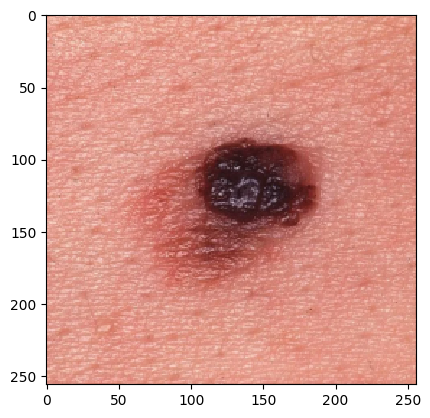

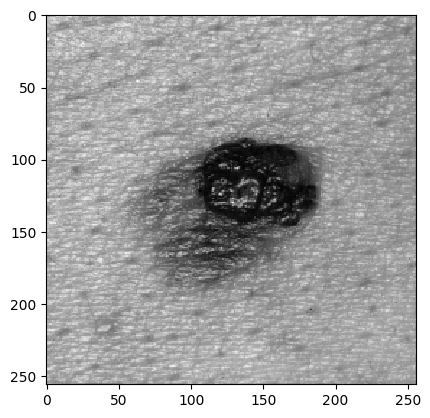

(564, 760, 3)


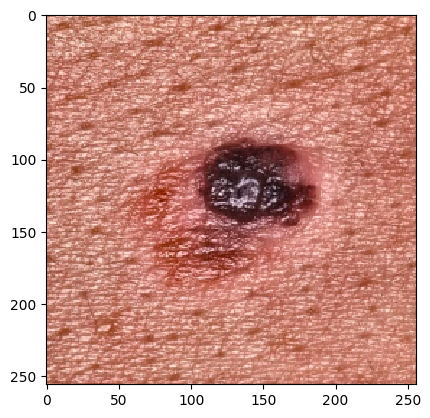

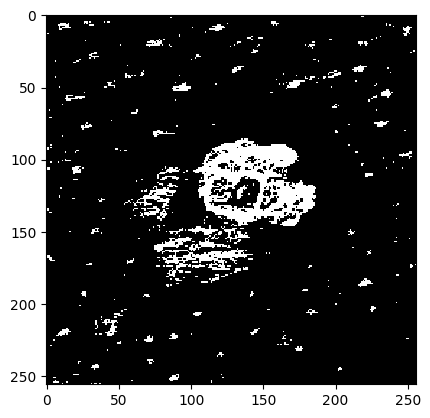

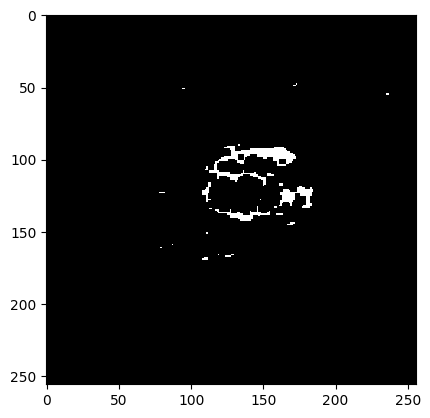

(256, 256, 3)


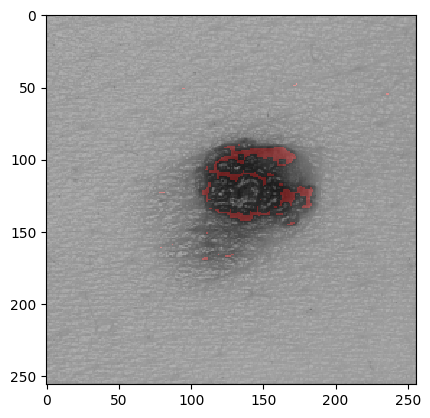

colored
<class 'numpy.ndarray'>
(256, 256)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Кол-во регионов = 23


23

In [ ]:
count_pores('MyProject/Data/Images/mole_pores2.jpg')

# Сегментация кожи на изображении